# Simulating Some Stuff ? TODO: title

## Setting up

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from math import *
from uncertainties import *
from scipy.stats import chi2
from matplotlib import gridspec
import pandas
import statsmodels.api as sm
import warnings ## statsmodels.api is too old ... -_-#

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["font.family"] = "serif" 
plt.rcParams["mathtext.fontset"] = "dejavuserif" 
plt.close("all") # close all existing matplotlib plots
# plt.ion()        # interact with plots without pausing program


In [2]:
import time
import random

In [302]:
from numba import jit, njit, prange
import numba

In [4]:
# import multiprocessing as mp
# # pool = mp.Pool(processes=7)

In [5]:
# from tqdm import tqdm
# from multiprocess import Pool

In [6]:
from joblib import Parallel, delayed

In [243]:
xmax = 10 #mm
nx = 101 # grid spacing
dt = 0.005 # s timesteps
dx = 2*xmax/(nx-1)
m3 = 3   # in atomic mass unit
m4 = 4 

In [244]:
xlin = np.linspace(-xmax,+xmax, nx)
psi=np.zeros((nx,nx,nx,nx),dtype=complex)

print(nx**4/1000/1000,"million grid points")
print((nx**4)*0.001/60/60,"hours (for 1ms per operation)")
print(psi.nbytes/1000/1000, "MB of data used")

104.060401 million grid points
28.90566694444444 hours (for 1ms per operation)
1664.966416 MB of data used


In [245]:
psi.shape

(101, 101, 101, 101)

In [246]:
hb=1
sg=0.2
# @njit(parallel=True)
def psi0(x31,x32,x41,x42,s3x=sg,s4x=sg,p31=0,p32=0,p41=0,p42=0):
    return (2/(pi*s3x*s4x)) \
            * np.exp(-(x31**2 + x32**2)/s3x**2) \
            * np.exp(-(x41**2 + x42**2)/s4x**2) \
            * np.exp(-(1j/hb)*(p31*x31+p32*x32))\
            * np.exp(-(1j/hb)*(p41*x41+p42*x42))

In [247]:
psi0(1,0,0,0,0.5,1,1,1,-1,-1)

(0.012599955520934188-0.019623268058611084j)

In [248]:
psi0(0,0,0,0,0.5,1,10,10,-10,-10)

(1.2732395447351628+0j)

In [270]:
def innerThreeLoops(i31):
    x31 = xlin[i31]
    for i32 in range(1,nx-1):
        x32 = xlin[i32]
        for i41 in range(1,nx-1):
            x41 = xlin[i41]
            psi[i31,i32,i41][1:-1] = psi0(x31,x32,x41,xlin[1:-1],0.5,1,  1,1,-3,-3)
            
results = Parallel(n_jobs=1, verbose=5, backend="threading")(map(delayed(innerThreeLoops), range(1,nx-1)))
psi0backup = psi.copy()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  99 out of  99 | elapsed:    9.8s finished


In [256]:
psi[0,0,0,0]

0j

In [257]:
psi[50,50,50,50]

(1.2732395447351628+0j)

In [258]:
psi[49,50,50,50]

(-0.723616572266479+0.8084352388003119j)

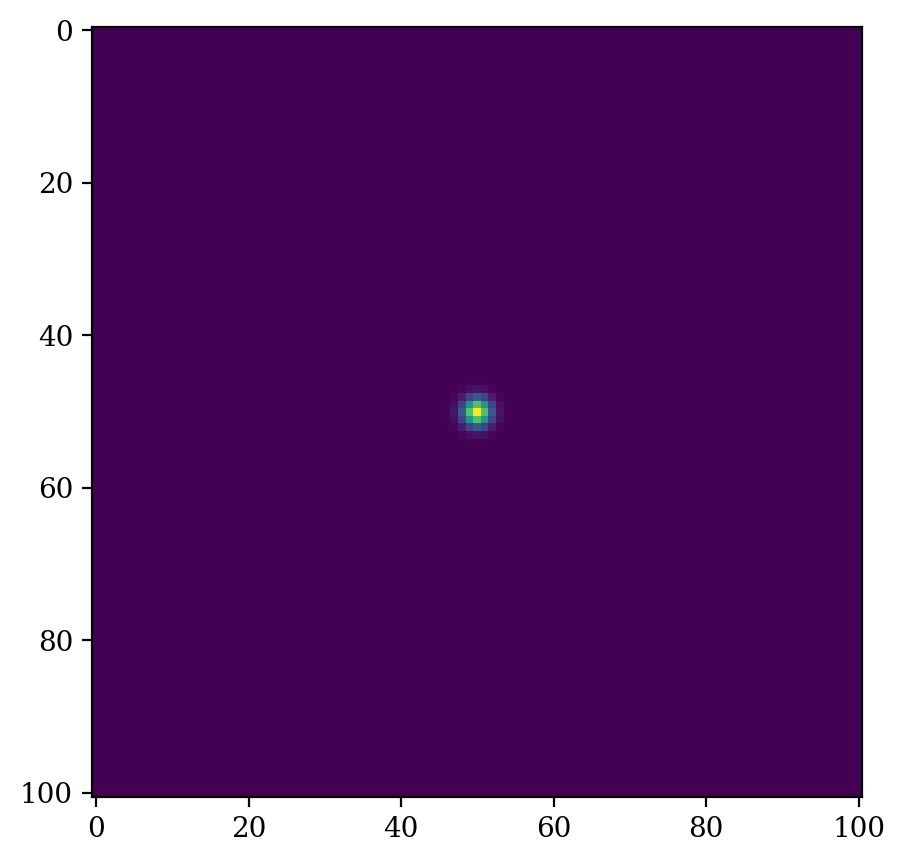

In [259]:
plt.imshow(np.sum(np.abs(psi)**2, axis=(2,3)))

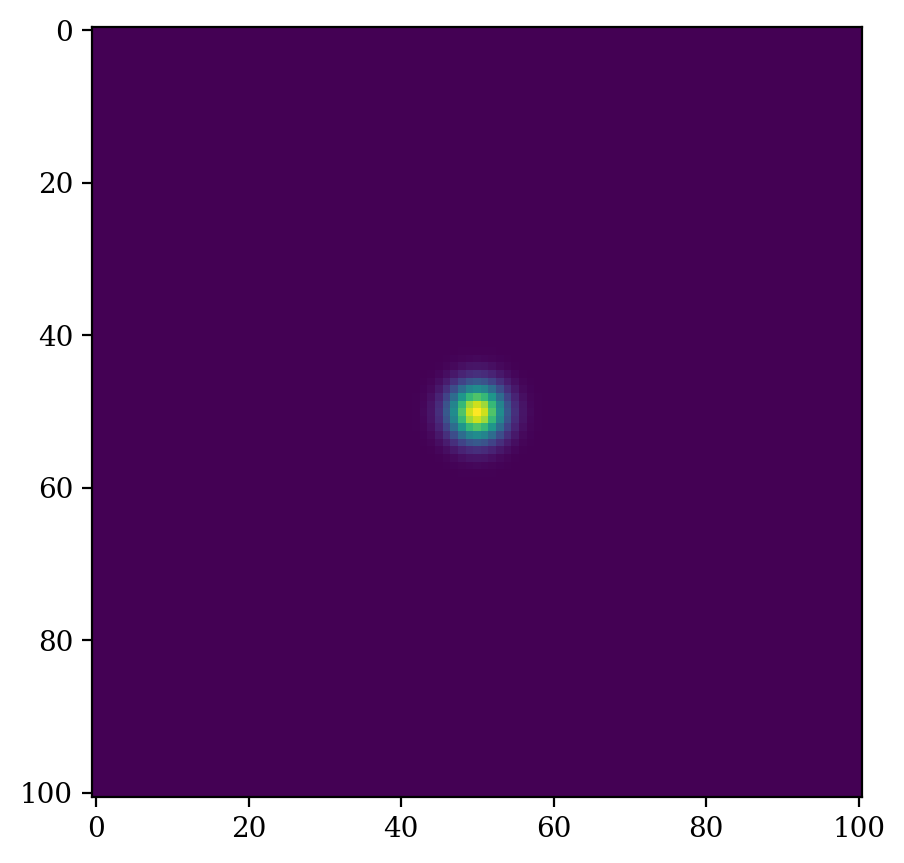

In [260]:
plt.imshow(np.sum(np.abs(psi)**2, axis=(0,1)))

Initial state generated

## Schrodinger equation

### Single timestep

In [261]:
added = 1j*hb*dt/(2*m3*dx**2)*(\
            psi[2:,1:-1,1:-1,1:-1] + psi[:-2,1:-1,1:-1,1:-1] \
          + psi[1:-1,2:,1:-1,1:-1] + psi[1:-1,:-2,1:-1,1:-1] - 4*psi[1:-1,1:-1,1:-1,1:-1])\
       +1j*hb*dt/(2*m4*dx**2)*(\
            psi[1:-1,1:-1,2:,1:-1] + psi[1:-1,1:-1,:-2,1:-1] \
          + psi[1:-1,1:-1,1:-1,2:] + psi[1:-1,1:-1,1:-1,:-2] - 4*psi[1:-1,1:-1,1:-1,1:-1])

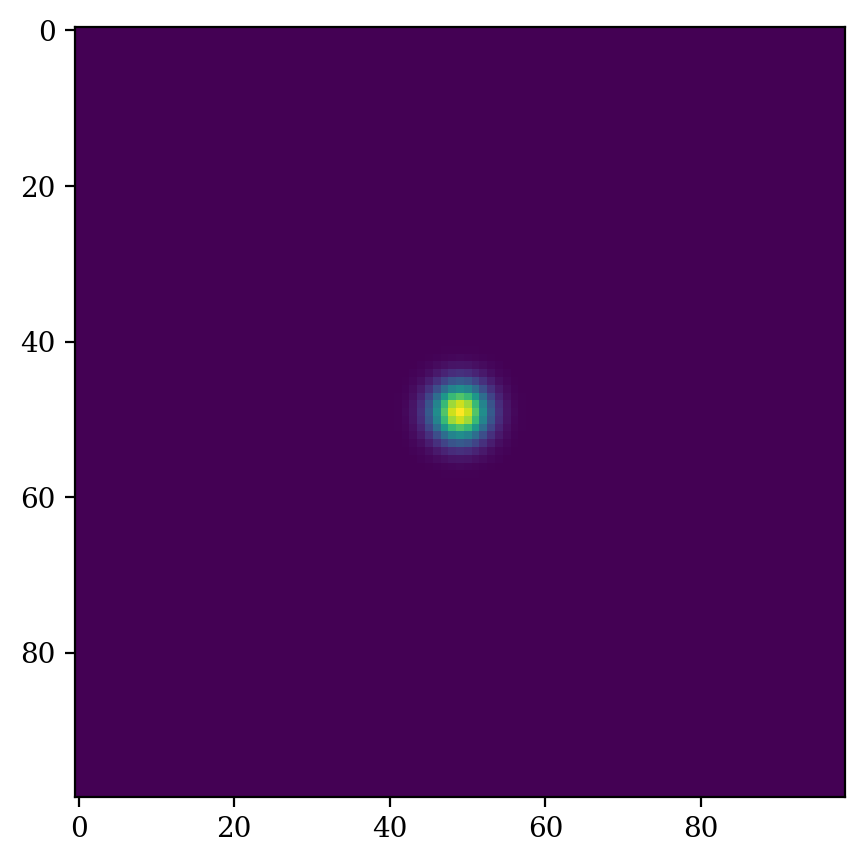

In [262]:
plt.imshow(np.sum(np.abs(added)**2, axis=(0,1)))

0.005 (1.2732395447351628-0.030608054514323992j)


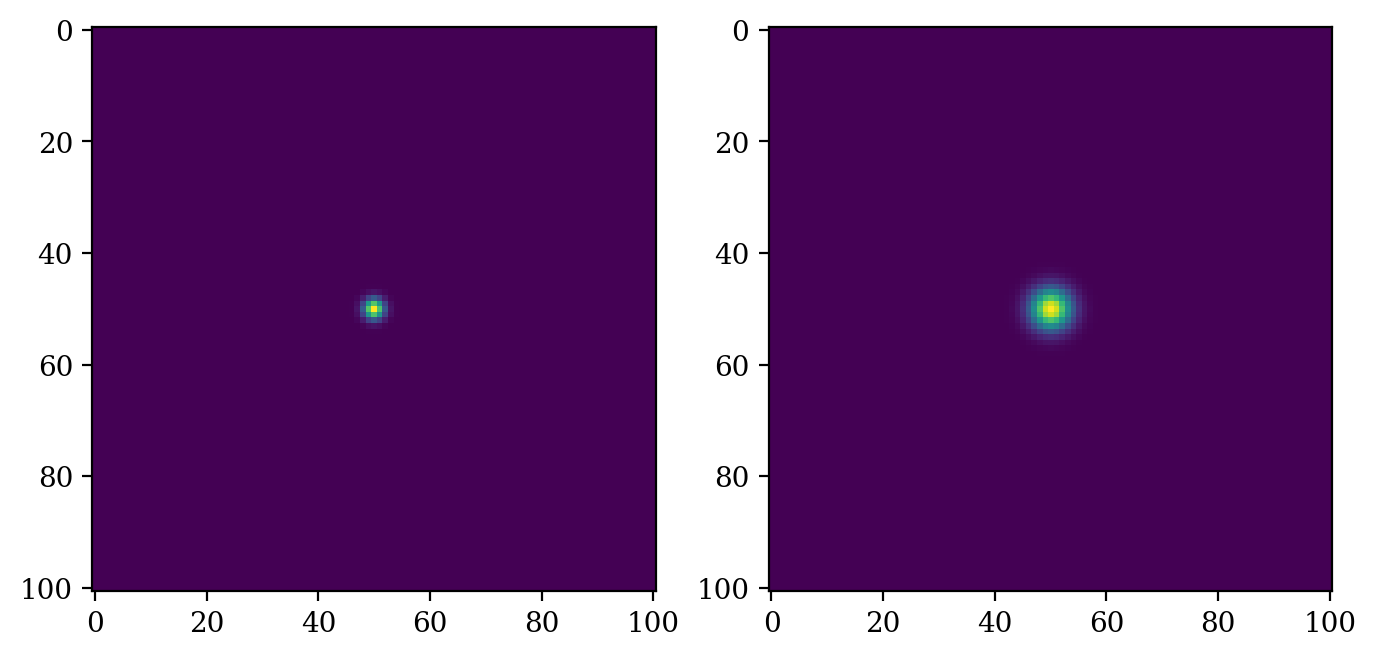

0.01 (1.2718897932437048-0.06121610902864802j)


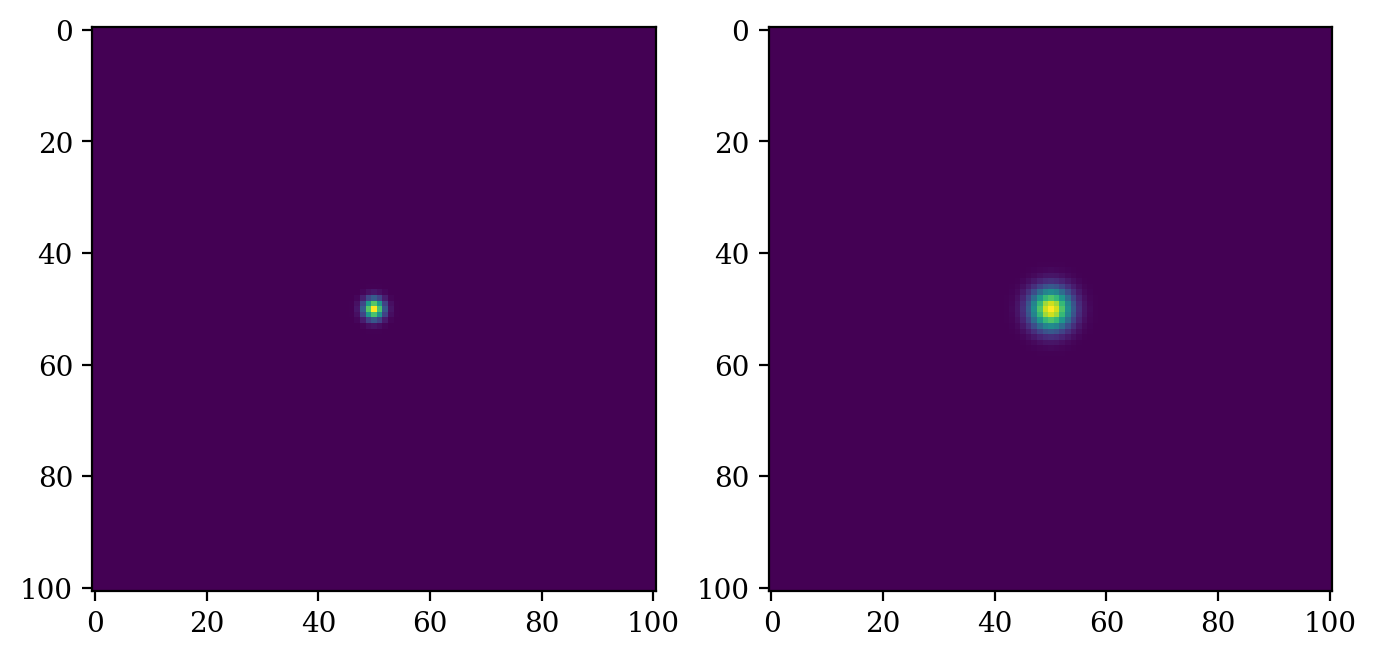

0.015 (1.2691902902607886-0.09174159327997106j)


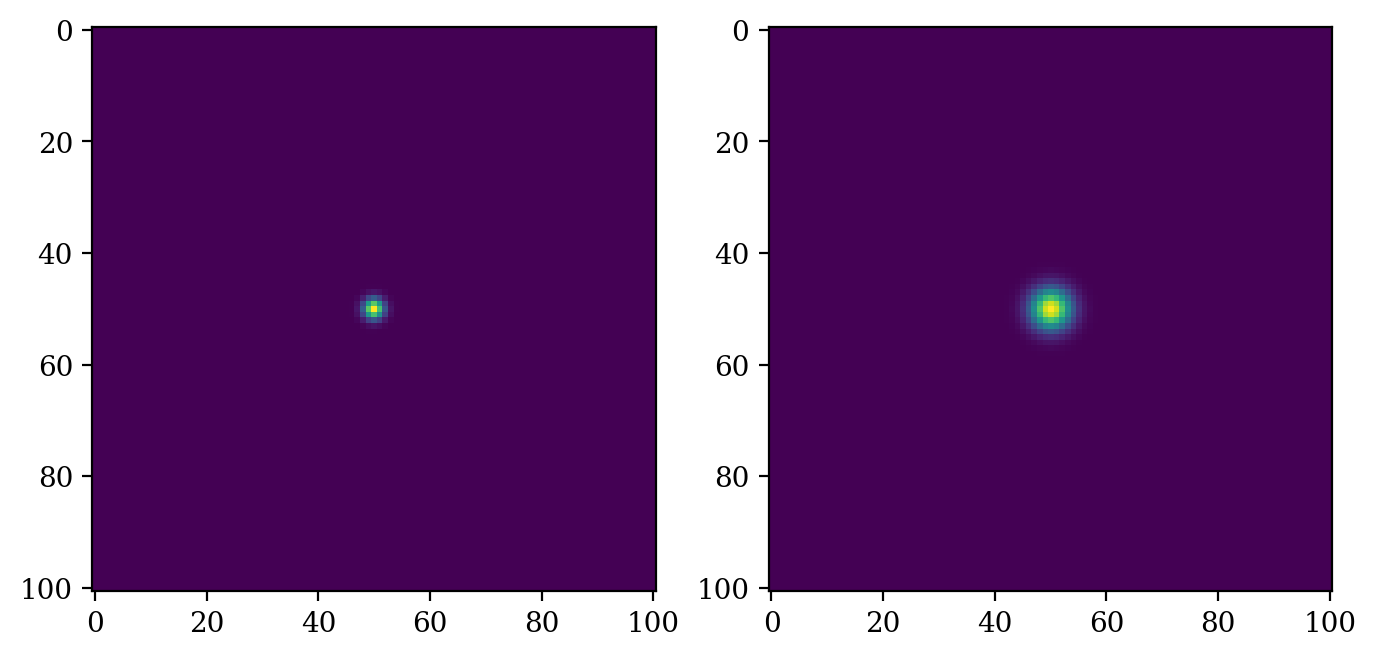

0.02 (1.265147313111533-0.12210193700529205j)


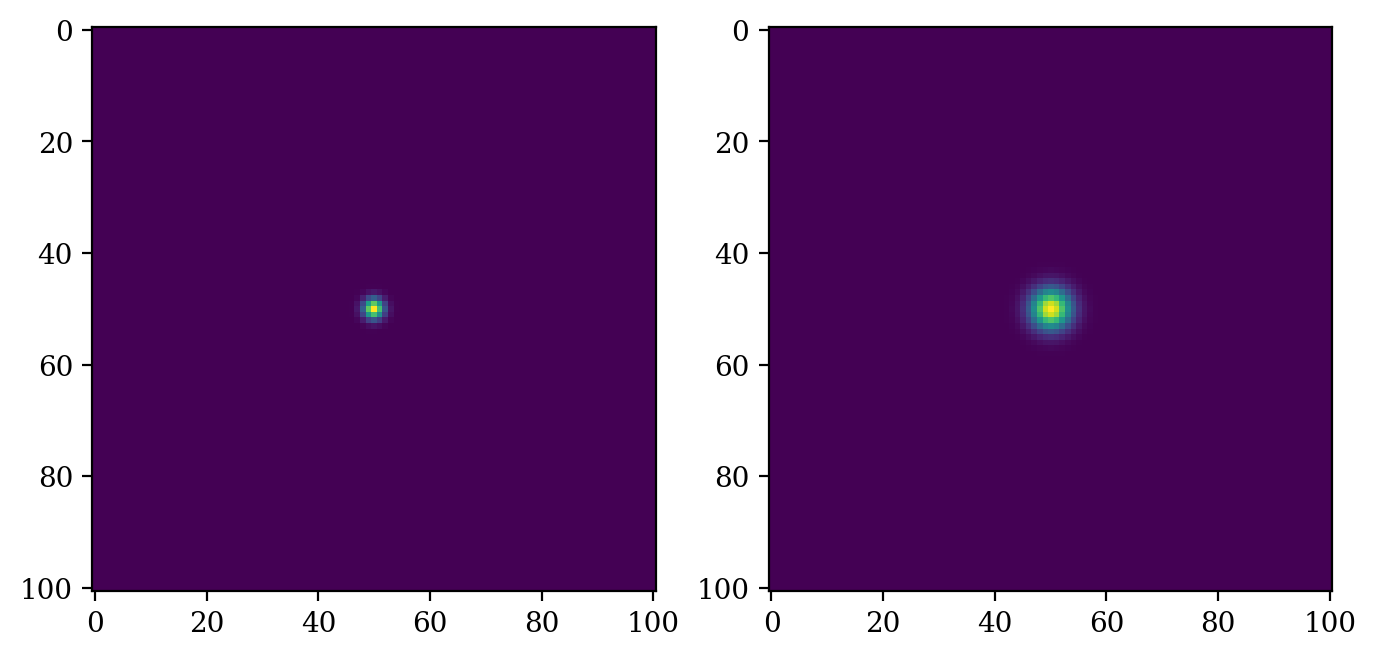

0.025 (1.259773416446176-0.15221512997683076j)


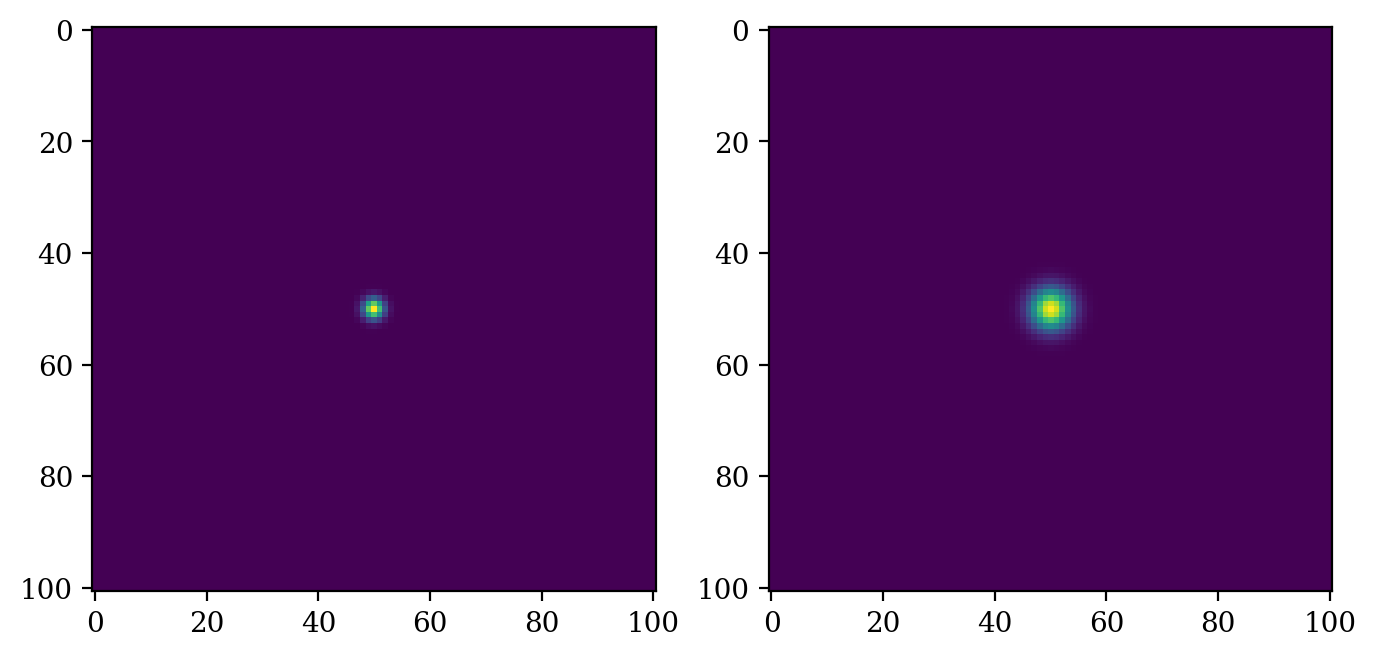

0.030000000000000002 (1.253087375580821-0.18200028203724836j)


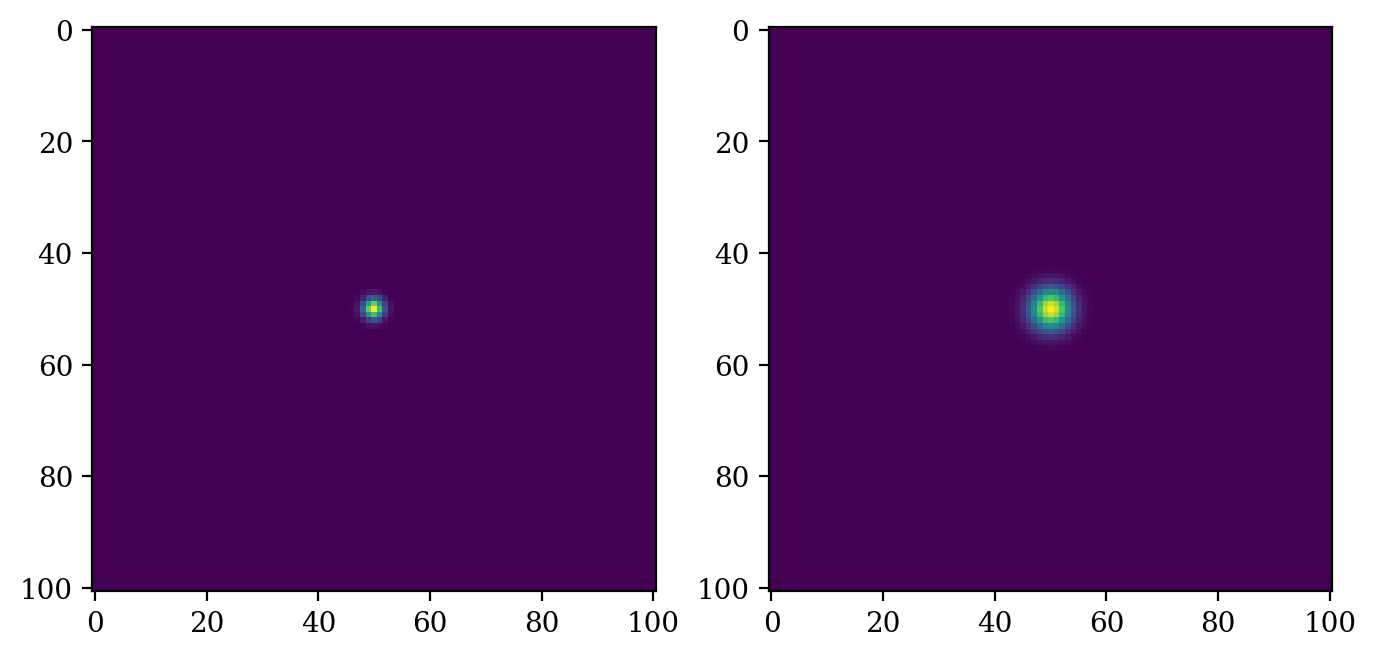

0.035 (1.24511407317893-0.21137817677813633j)


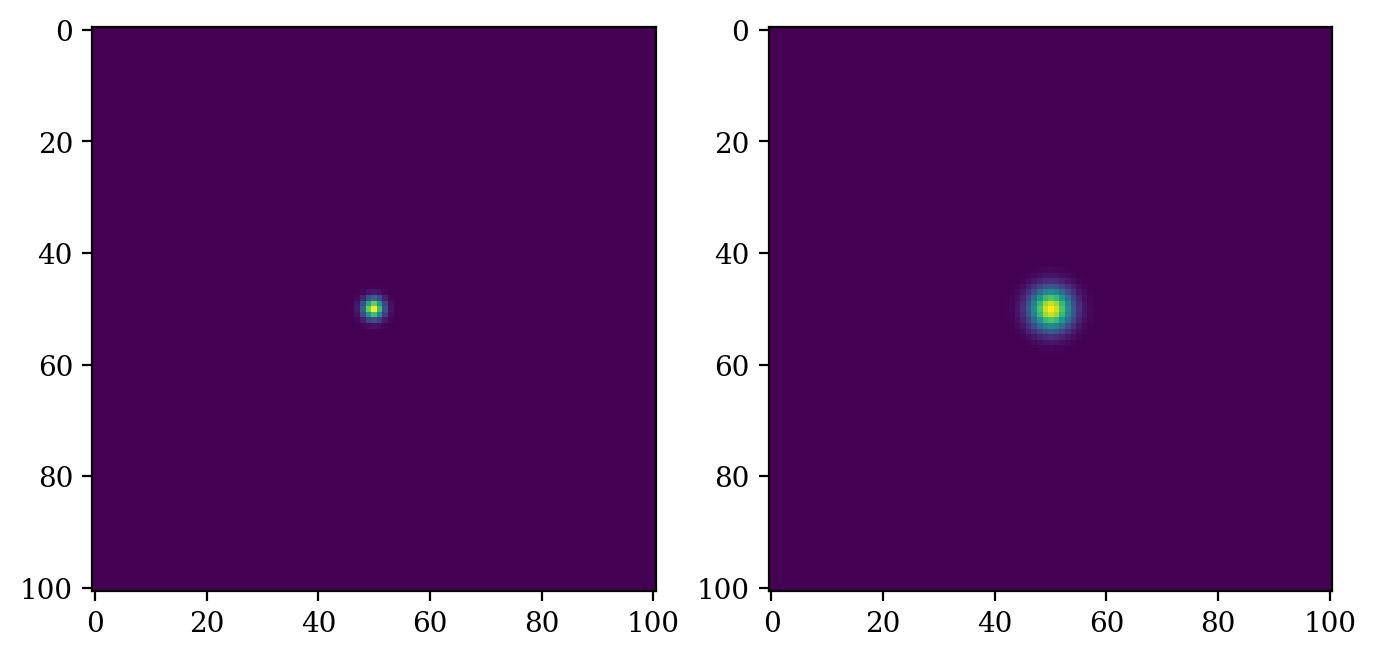

0.04 (1.2358843300521631-0.24027181250504093j)


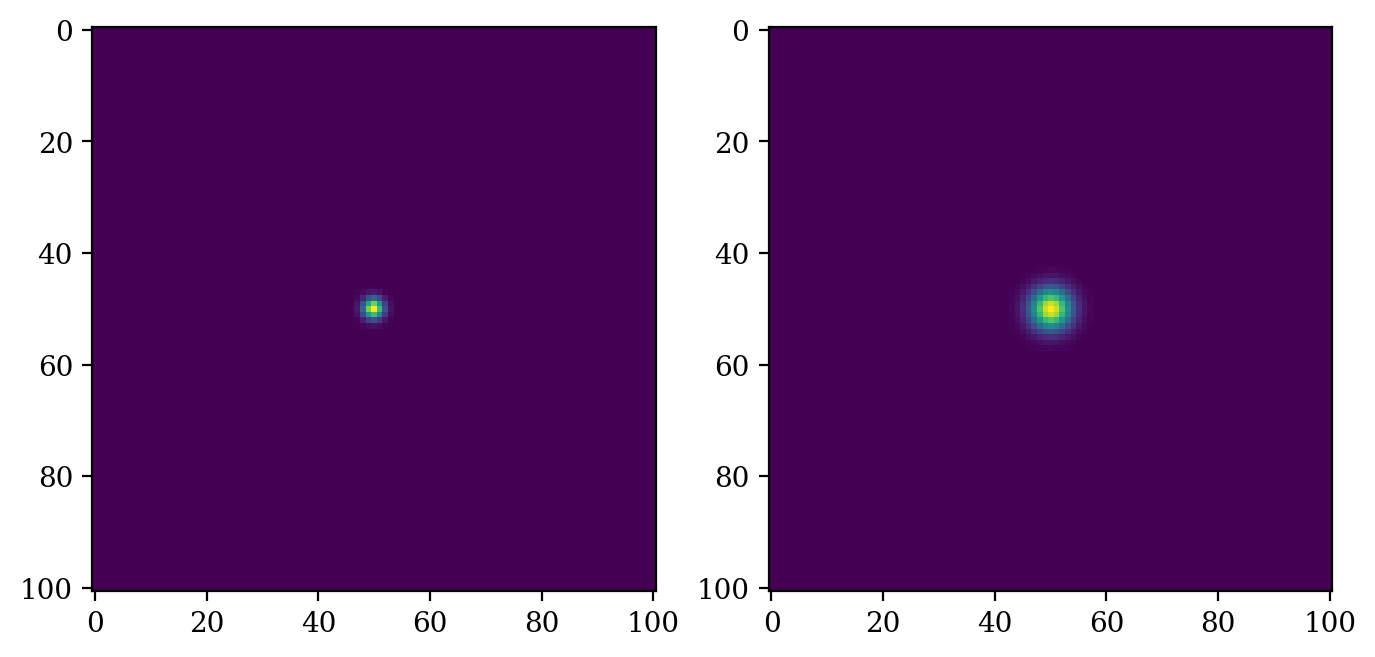

0.045 (1.2254346816377577-0.2686069242352004j)


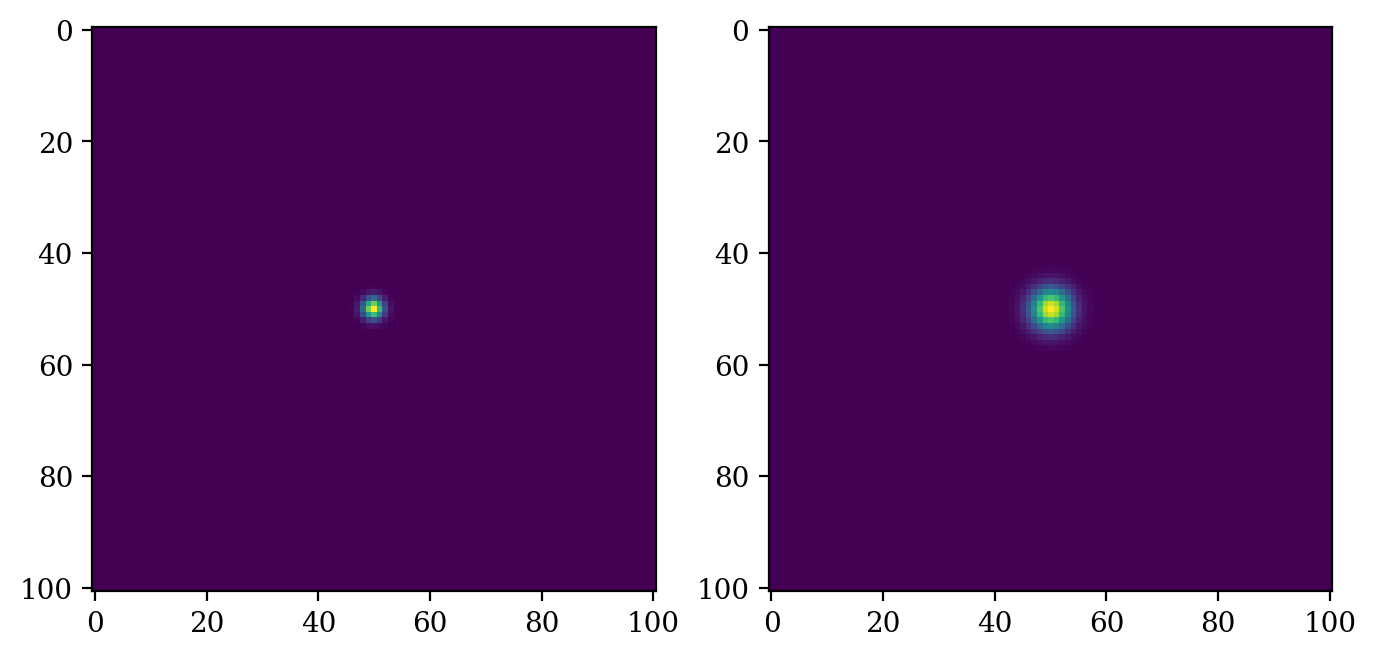

0.049999999999999996 (1.2138071024737054-0.29631248067998794j)


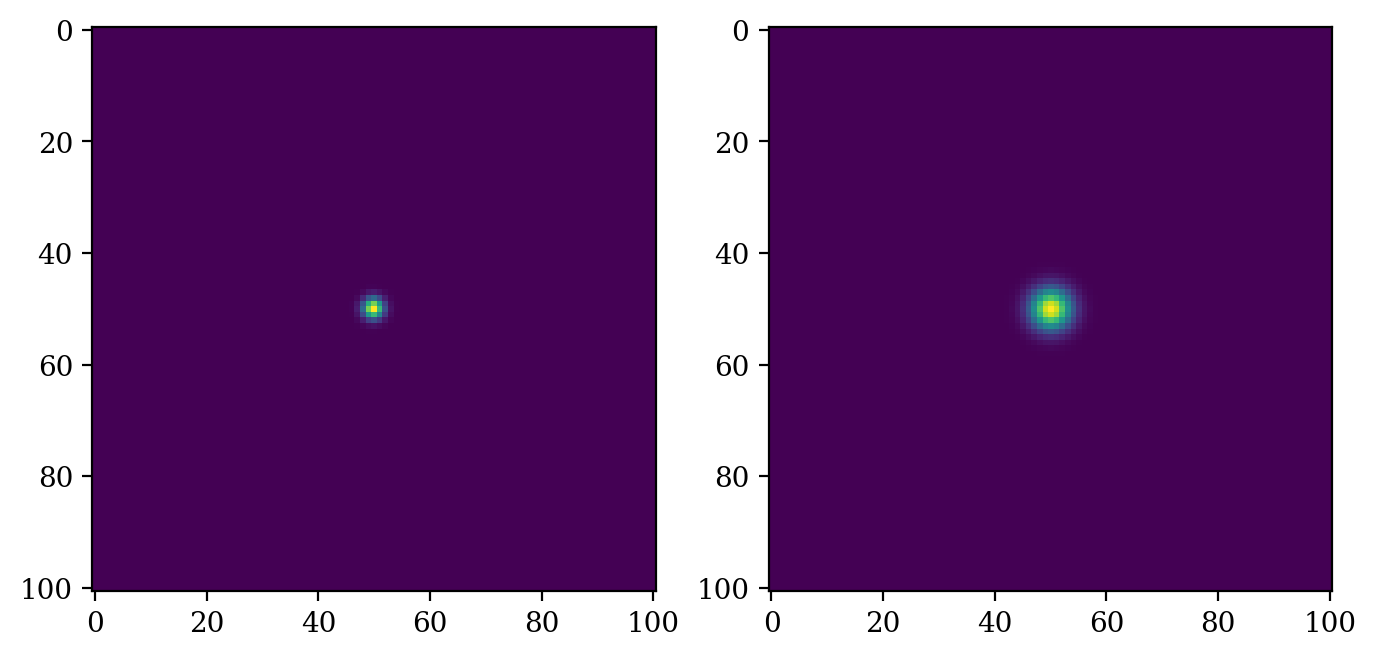

0.05499999999999999 (1.2010486817279433-0.32332115047059934j)


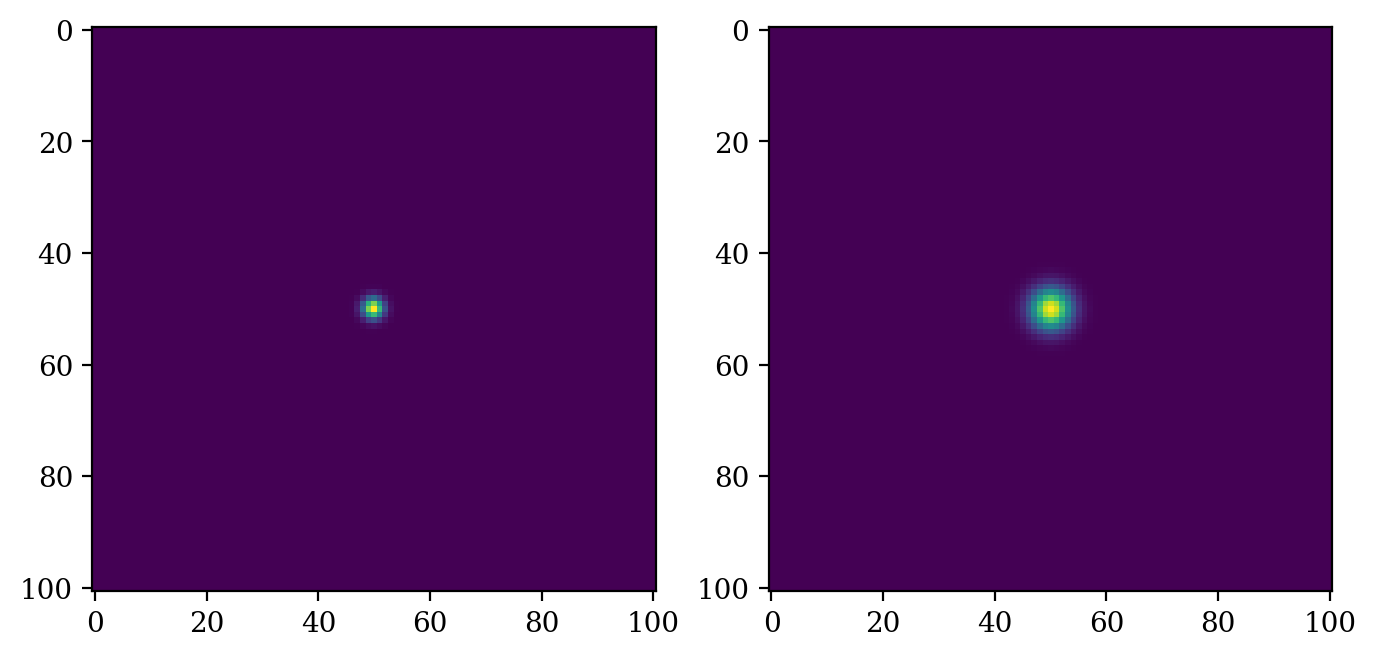

0.05999999999999999 (1.1872112535294708-0.34956973228843374j)


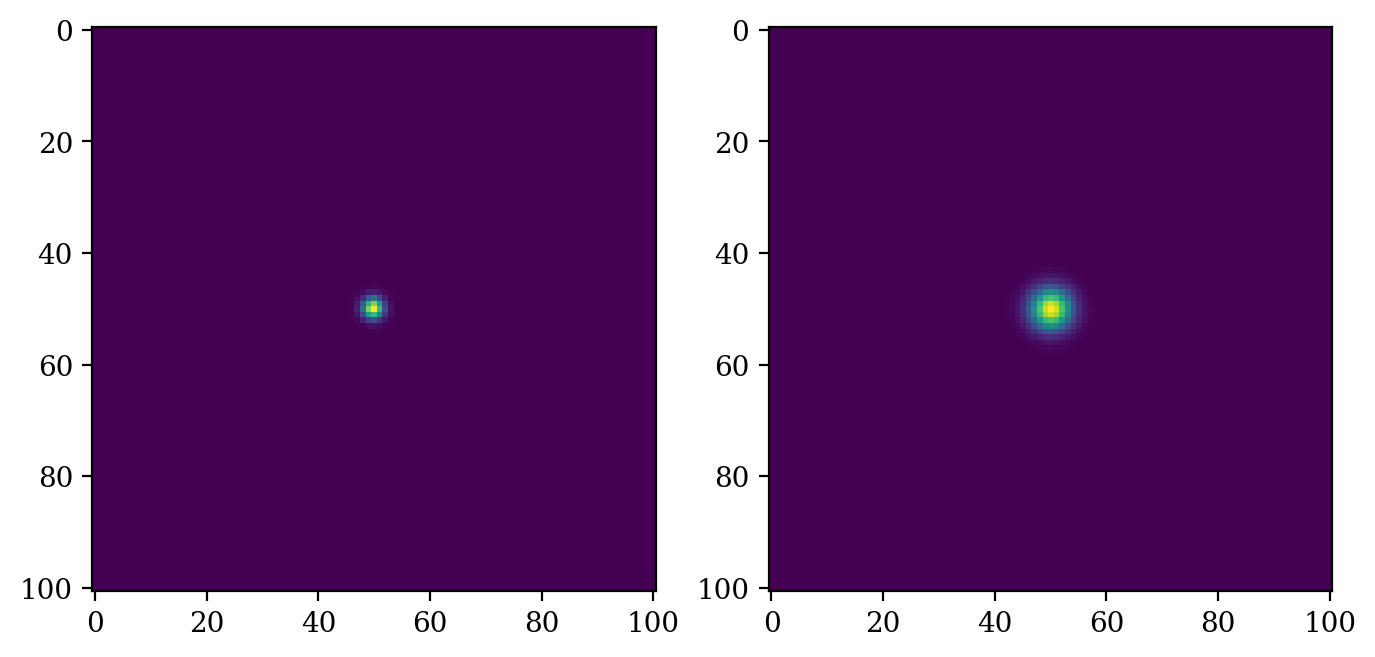

0.06499999999999999 (1.1723509864841861-0.37499954405440955j)


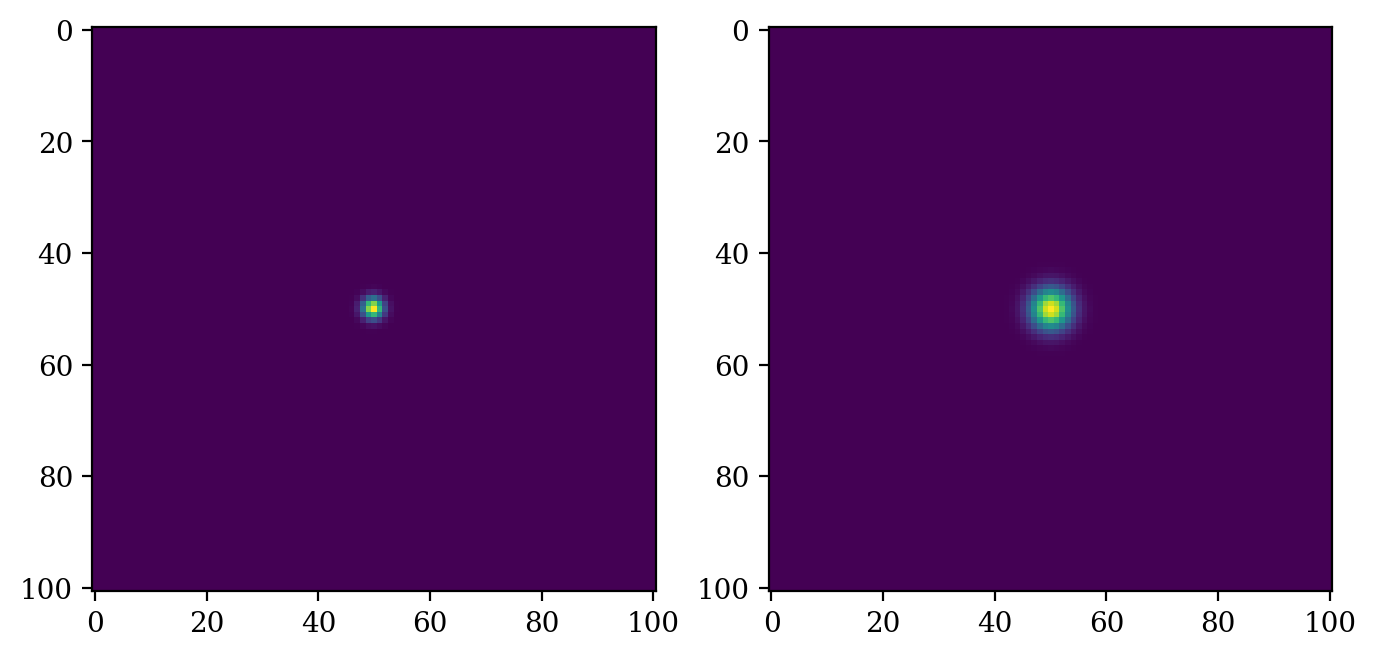

0.06999999999999999 (1.15652793732386-0.3995567669056329j)


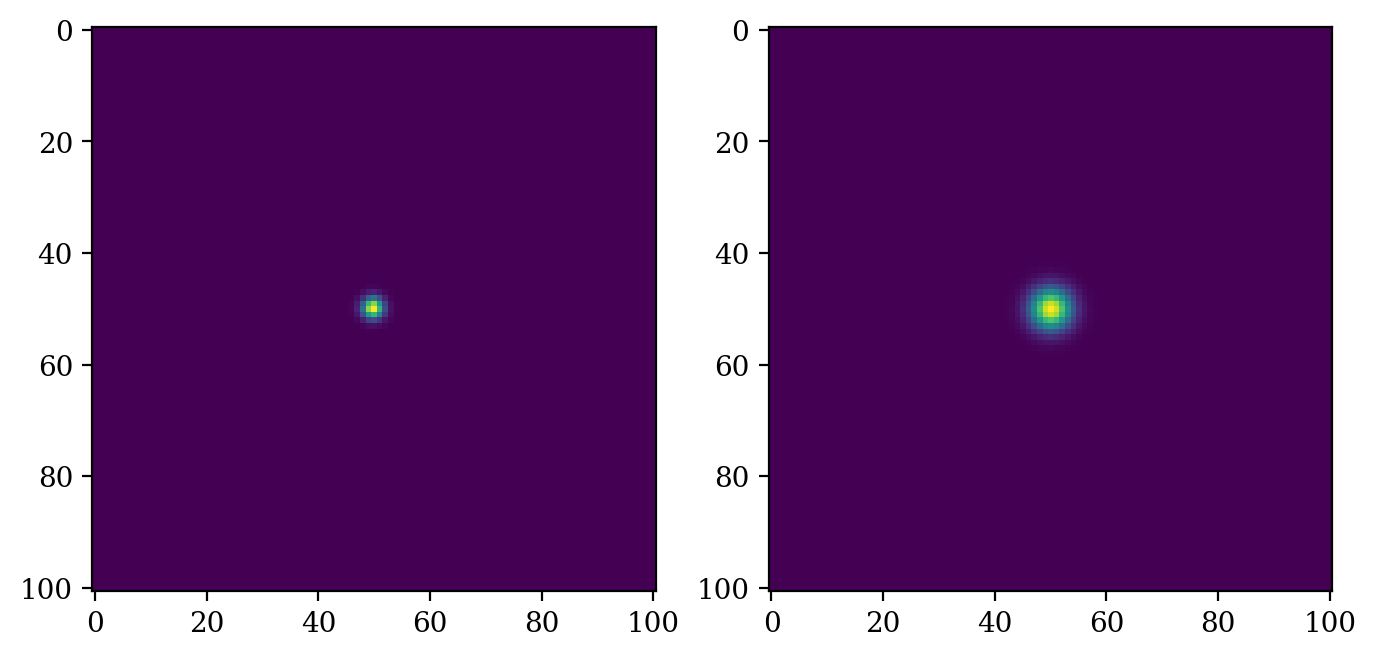

0.075 (1.1398055741218474-0.4231927403330671j)


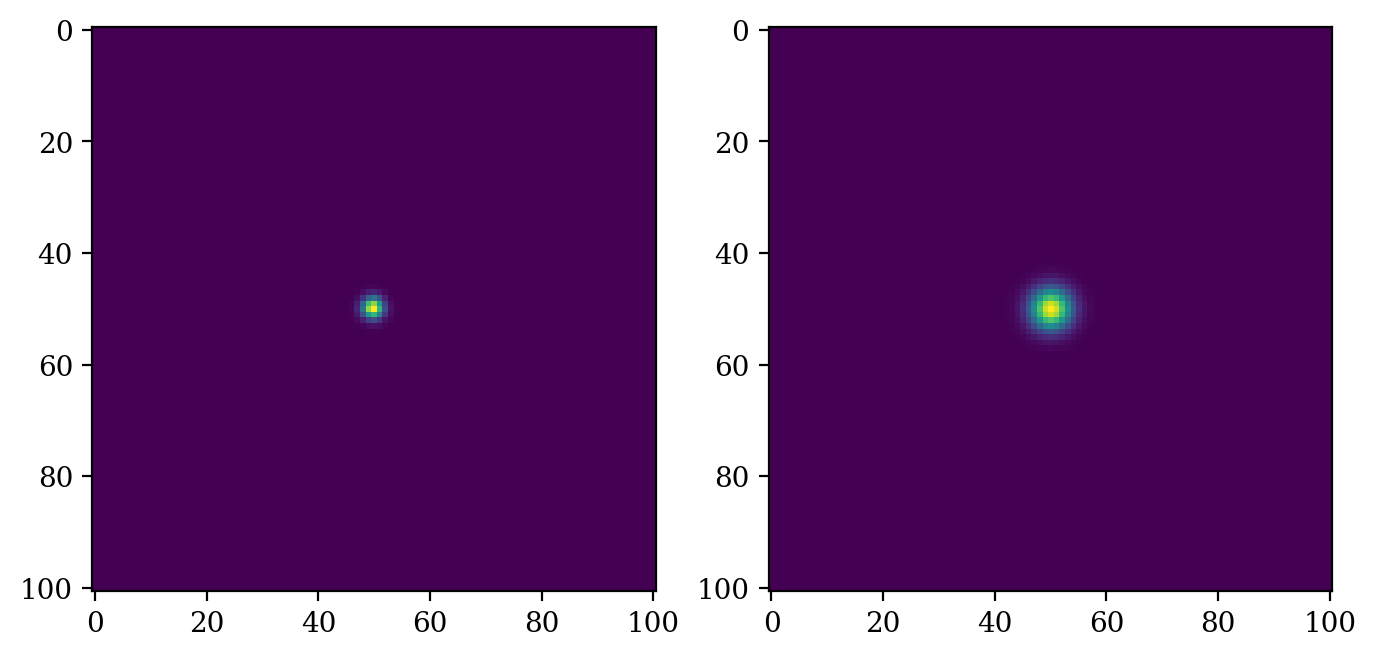

0.08 (1.122250274904391-0.4458642055581775j)


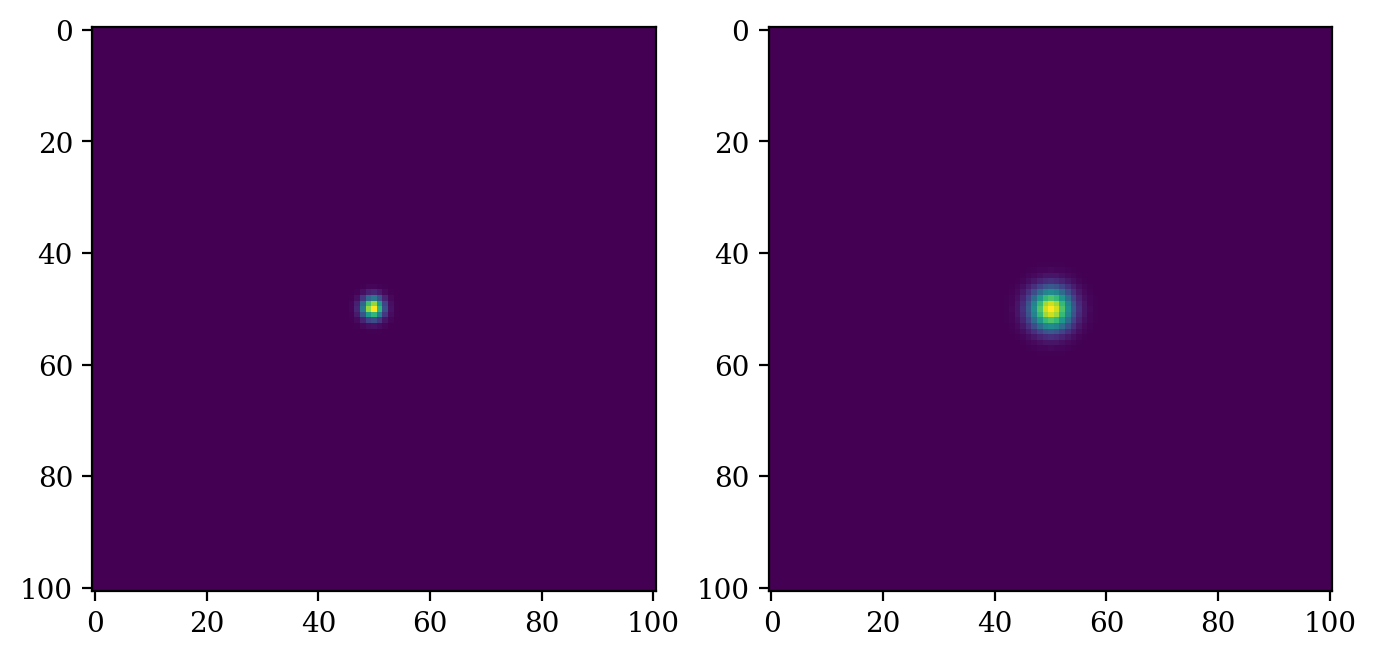

0.085 (1.1039308077840326-0.46753349497664937j)


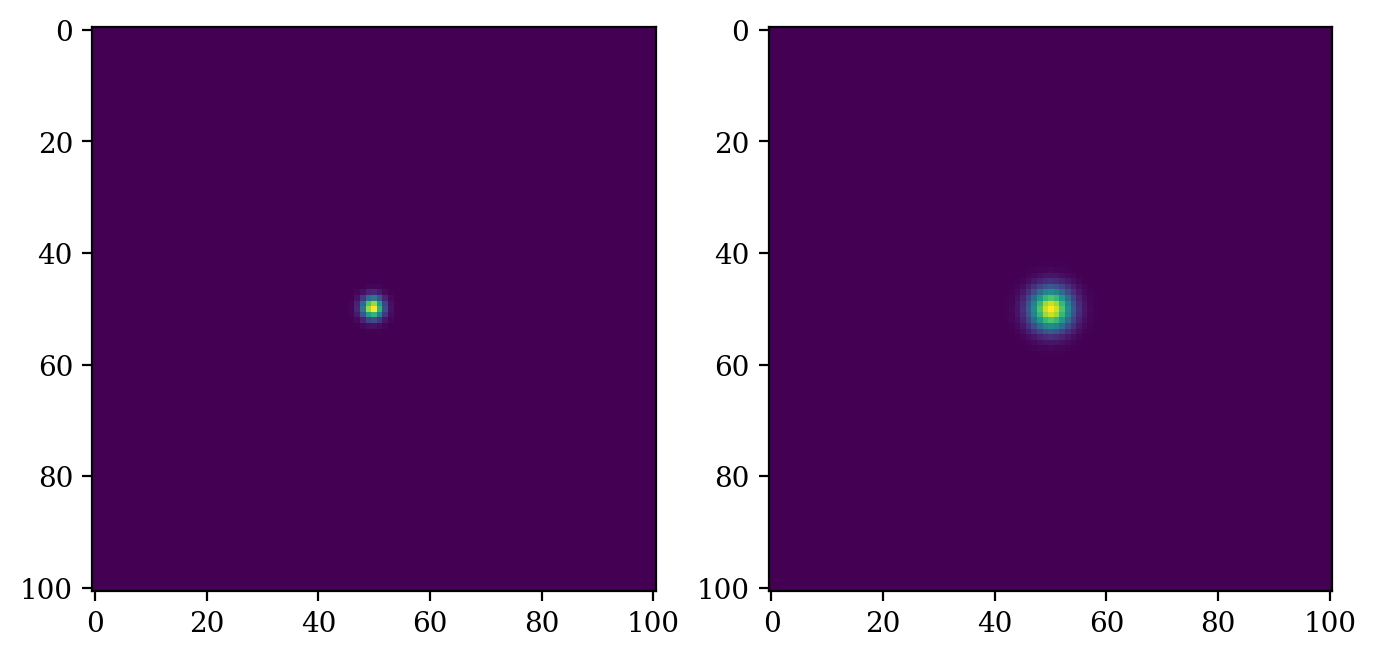

0.09000000000000001 (1.0849177989361443-0.48816866627884653j)


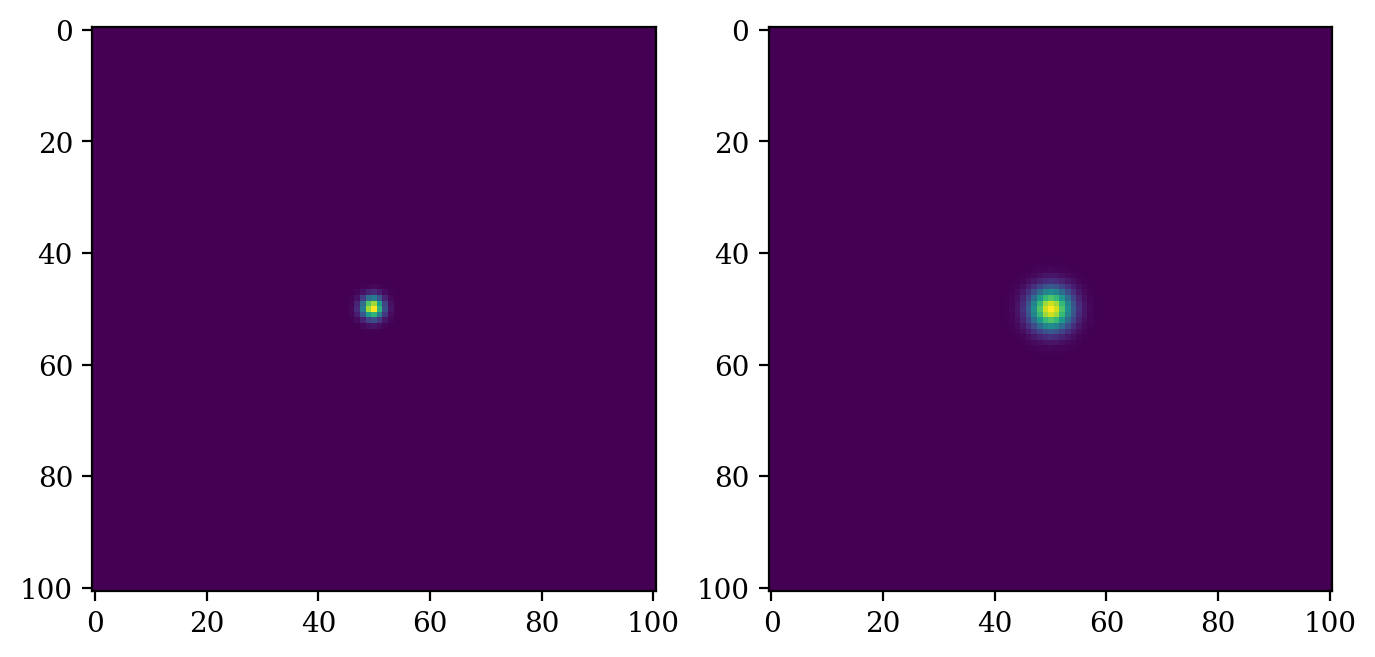

0.09500000000000001 (1.0652831948275878-0.5077435806546488j)


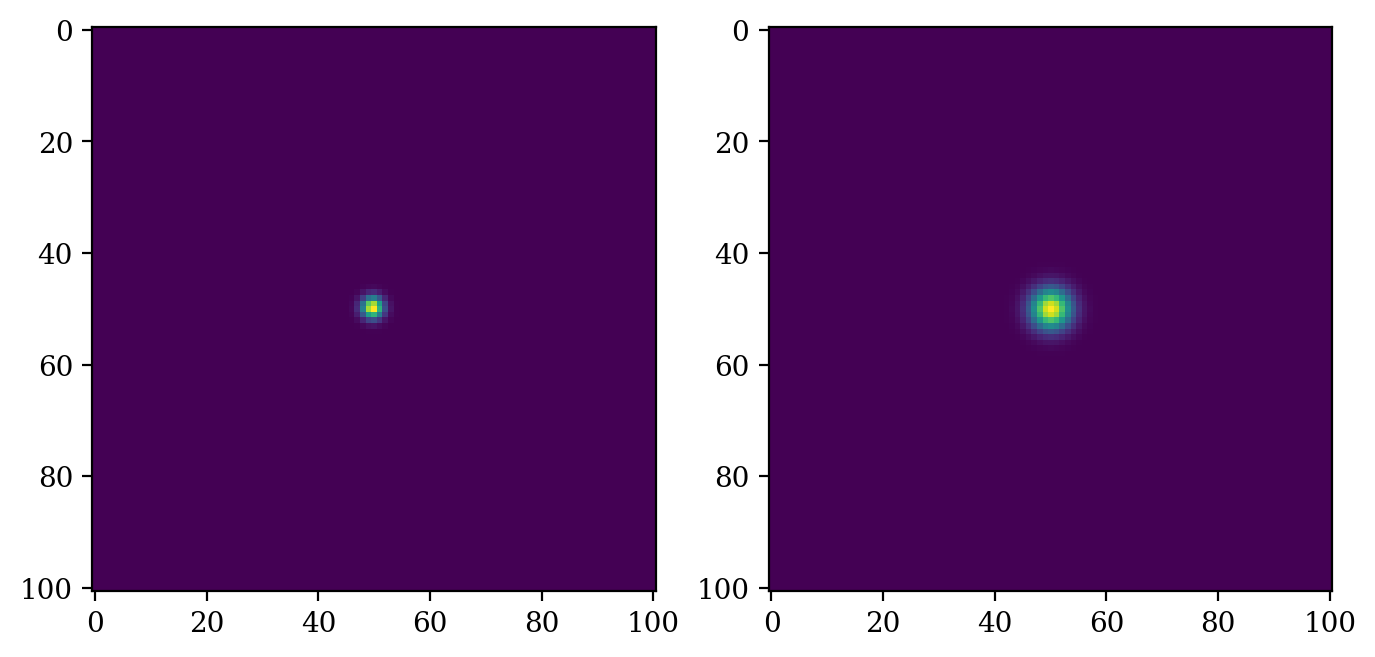

0.10000000000000002 (1.0450997250869523-0.5262379252892815j)


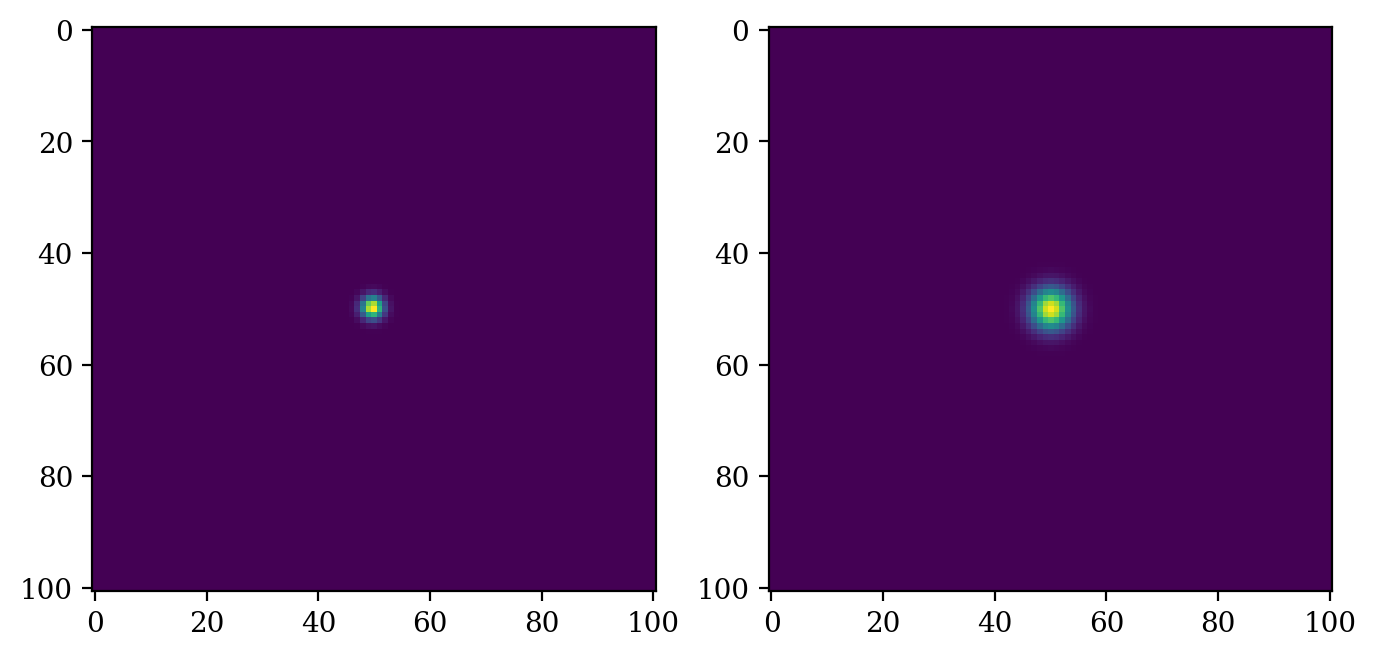

0.10500000000000002 (1.0244403722800441-0.5436371811413737j)


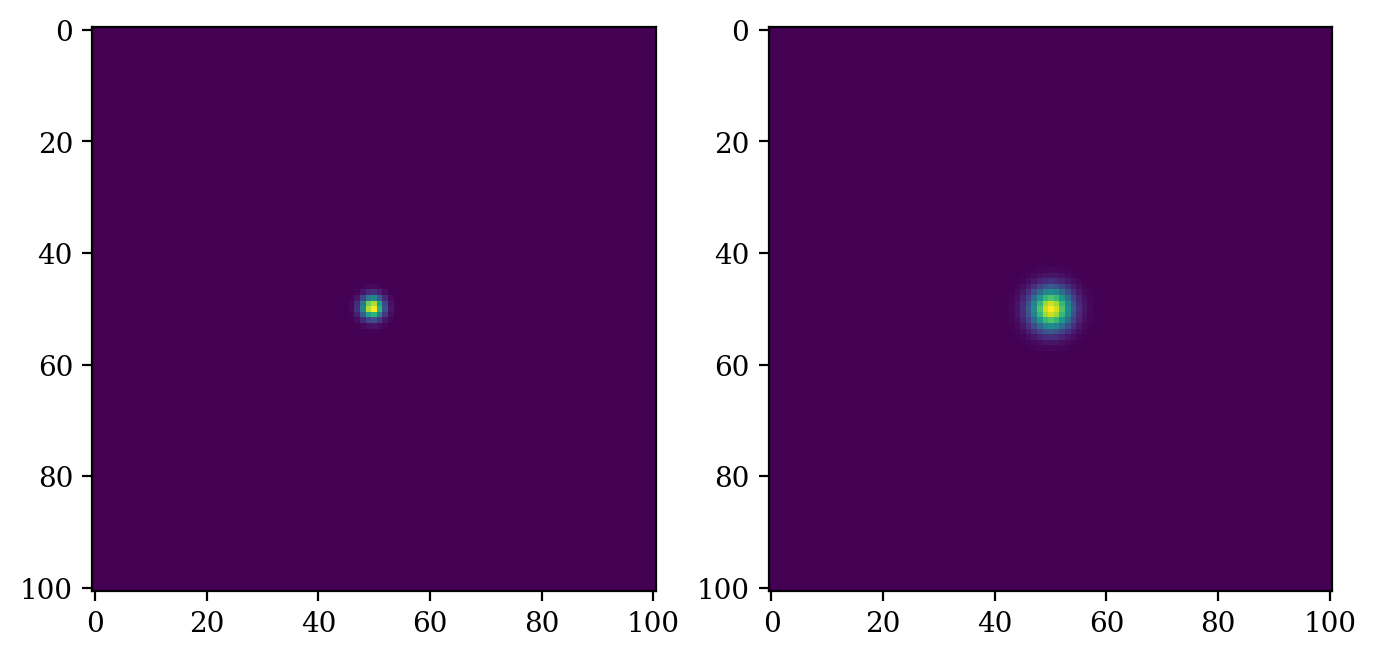

0.11000000000000003 (1.0033778546259025-0.5599325377497925j)


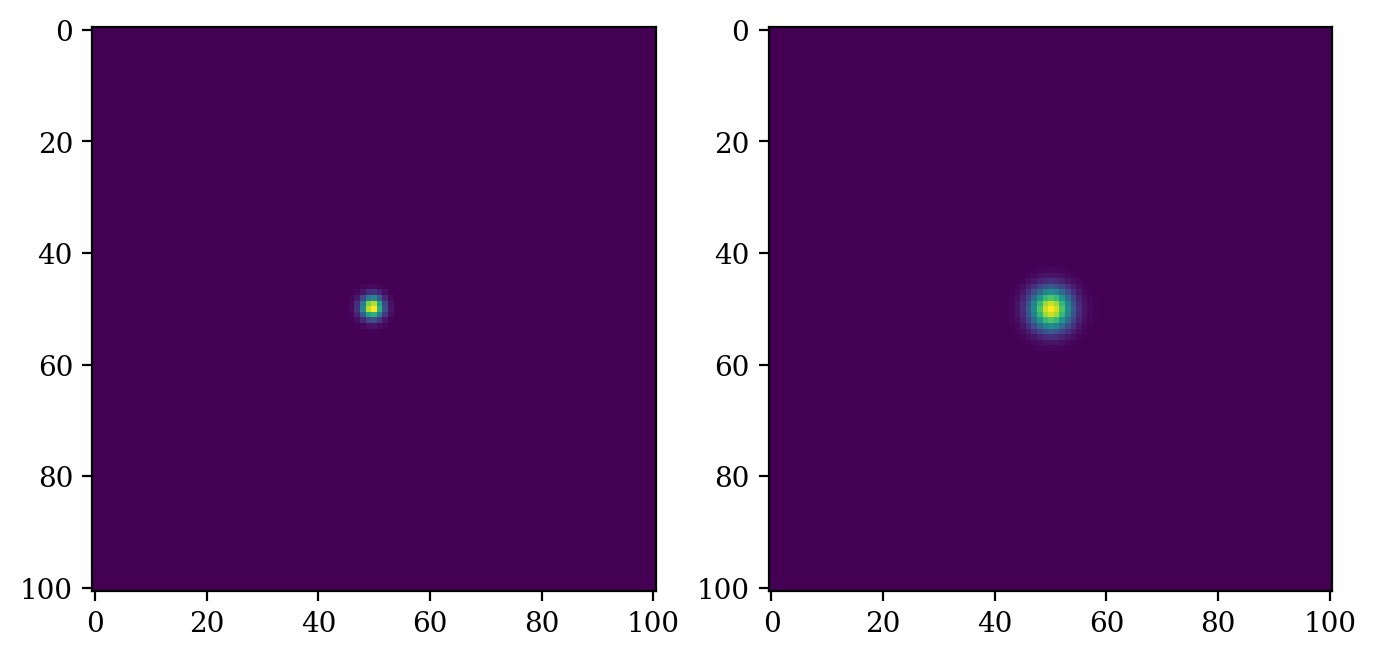

0.11500000000000003 (0.981984127363448-0.5751207575276154j)


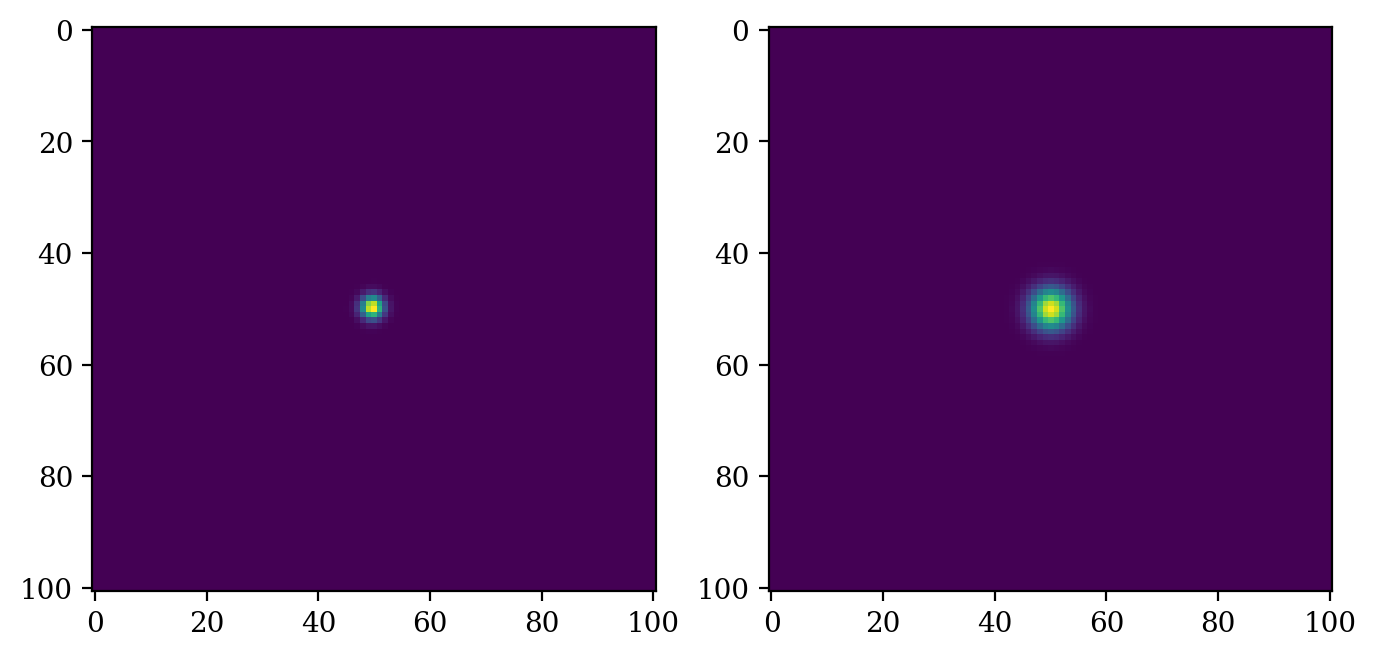

0.12000000000000004 (0.9603299080648314-0.5892039926568505j)


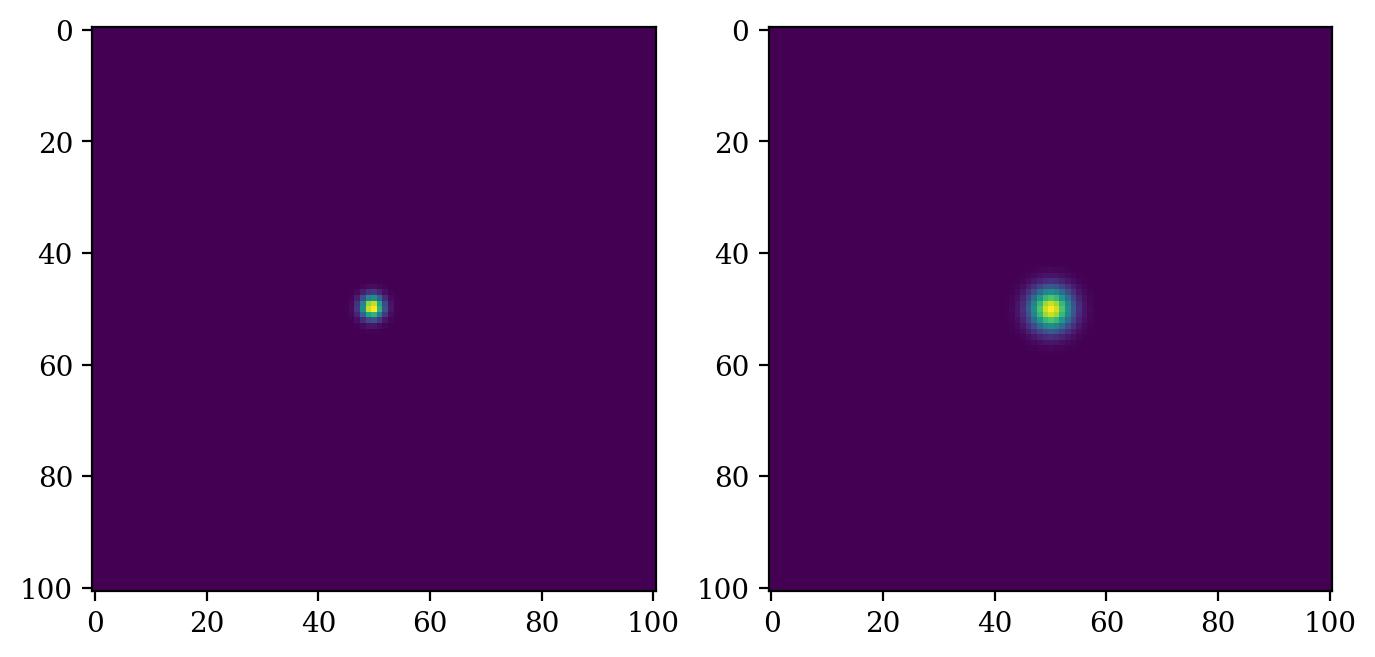

0.12500000000000003 (0.9384842306983768-0.6021895582845411j)


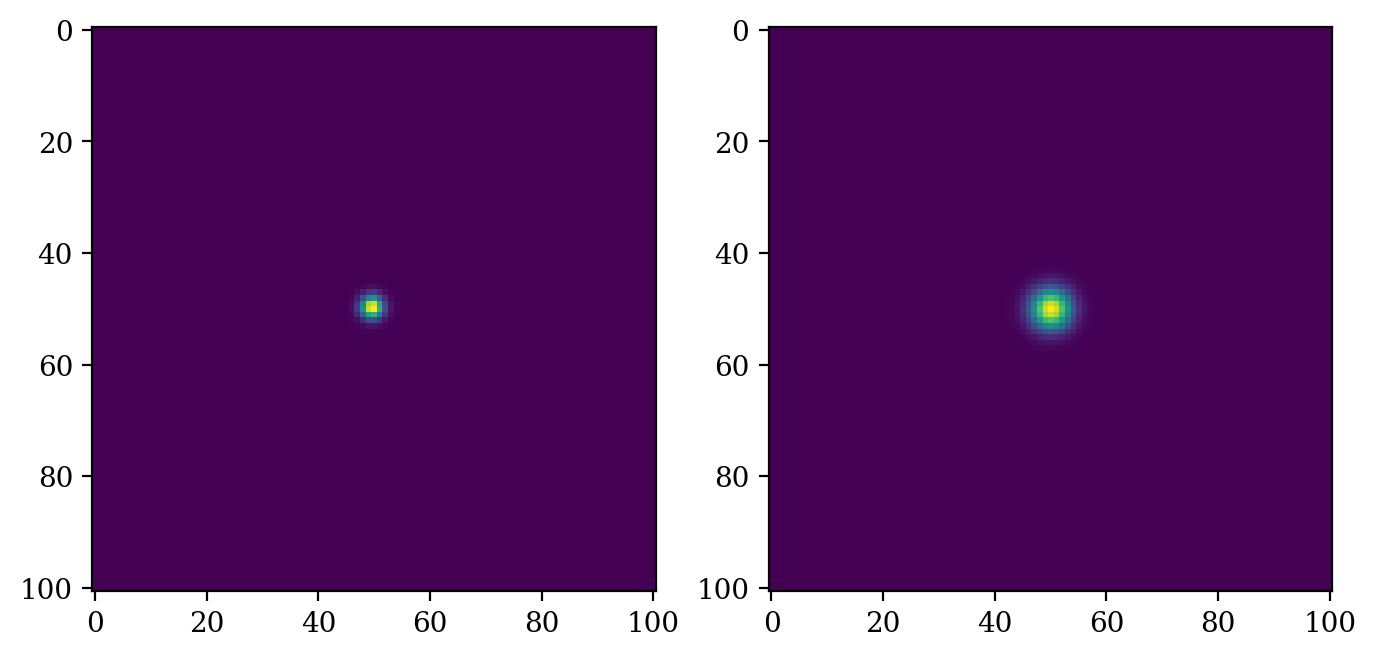

0.13000000000000003 (0.9165140326830563-0.6140896662297547j)


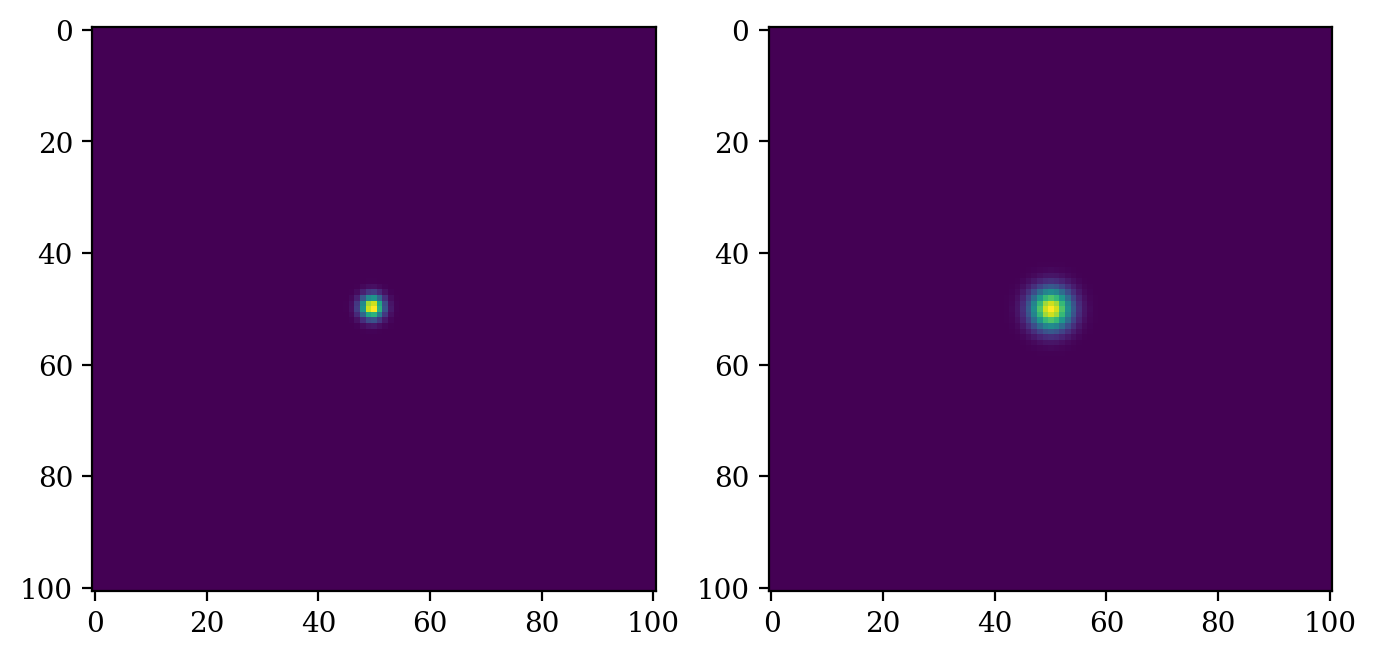

0.13500000000000004 (0.8944837785603132-0.6249211238336345j)


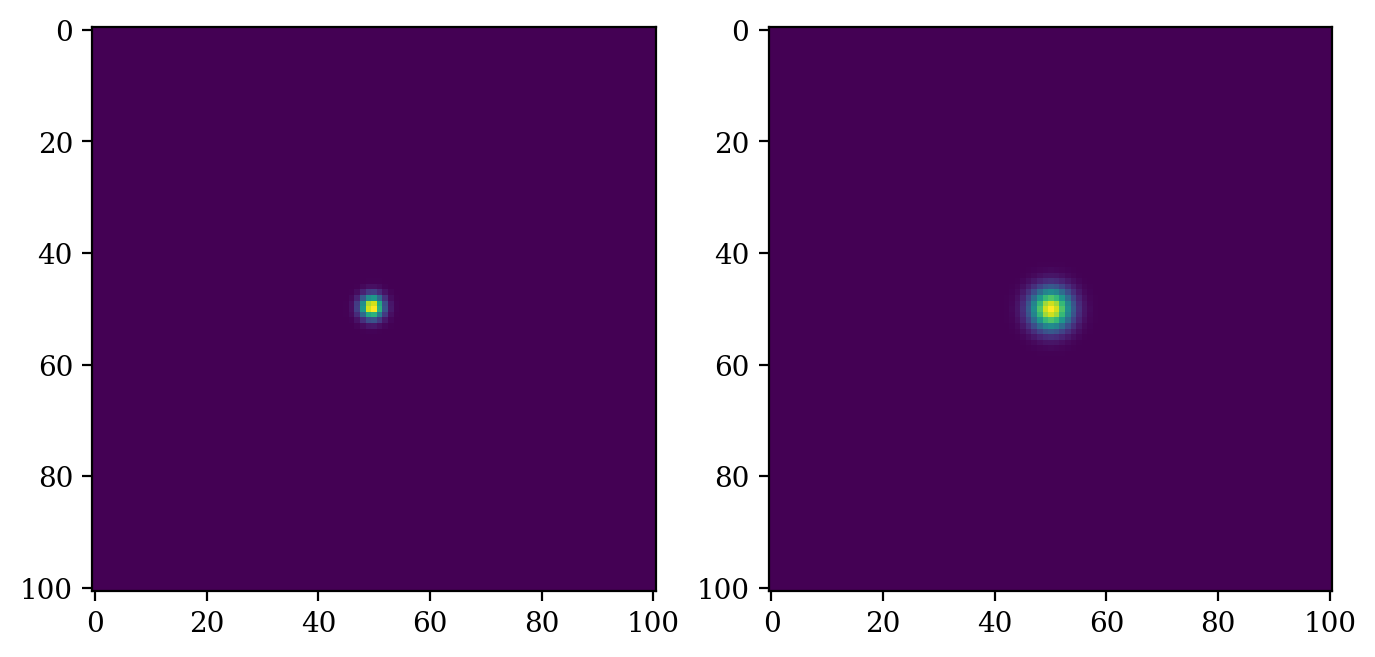

0.14000000000000004 (0.8724551232513403-0.6347050029152379j)


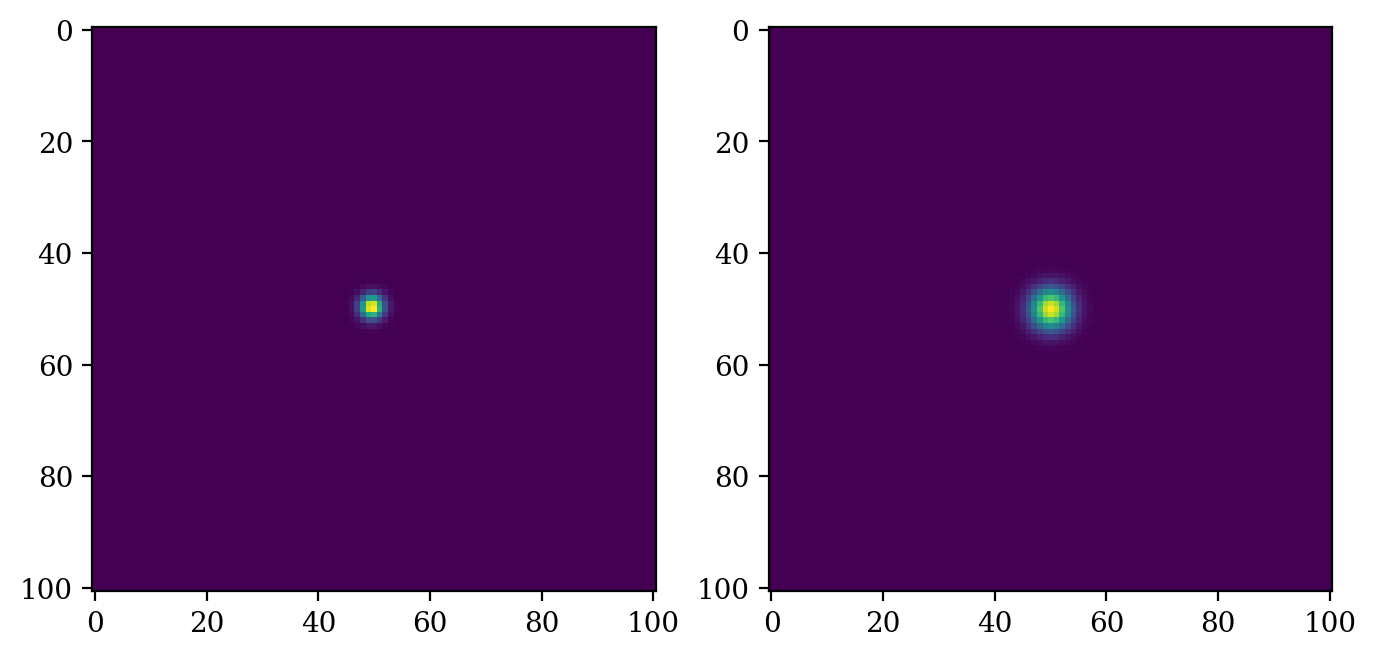

0.14500000000000005 (0.8504866171828059-0.6434662840305837j)


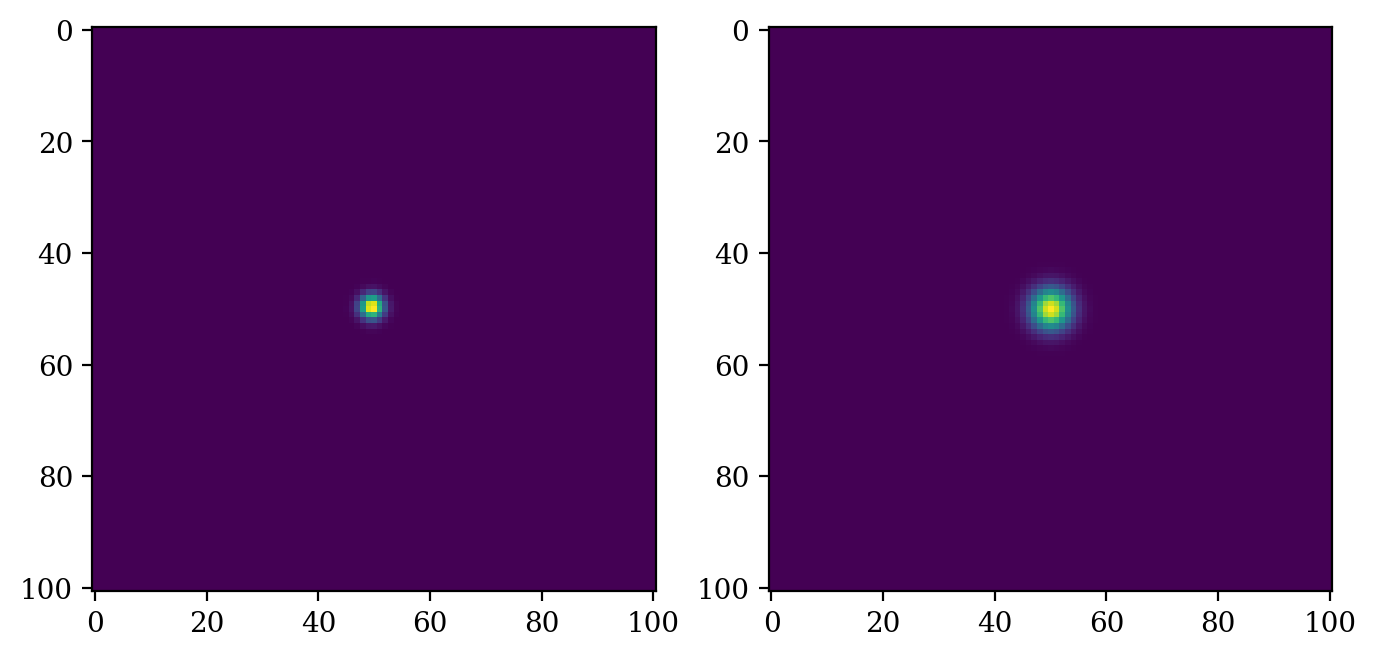

0.15000000000000005 (0.828633454865904-0.6512334813696926j)


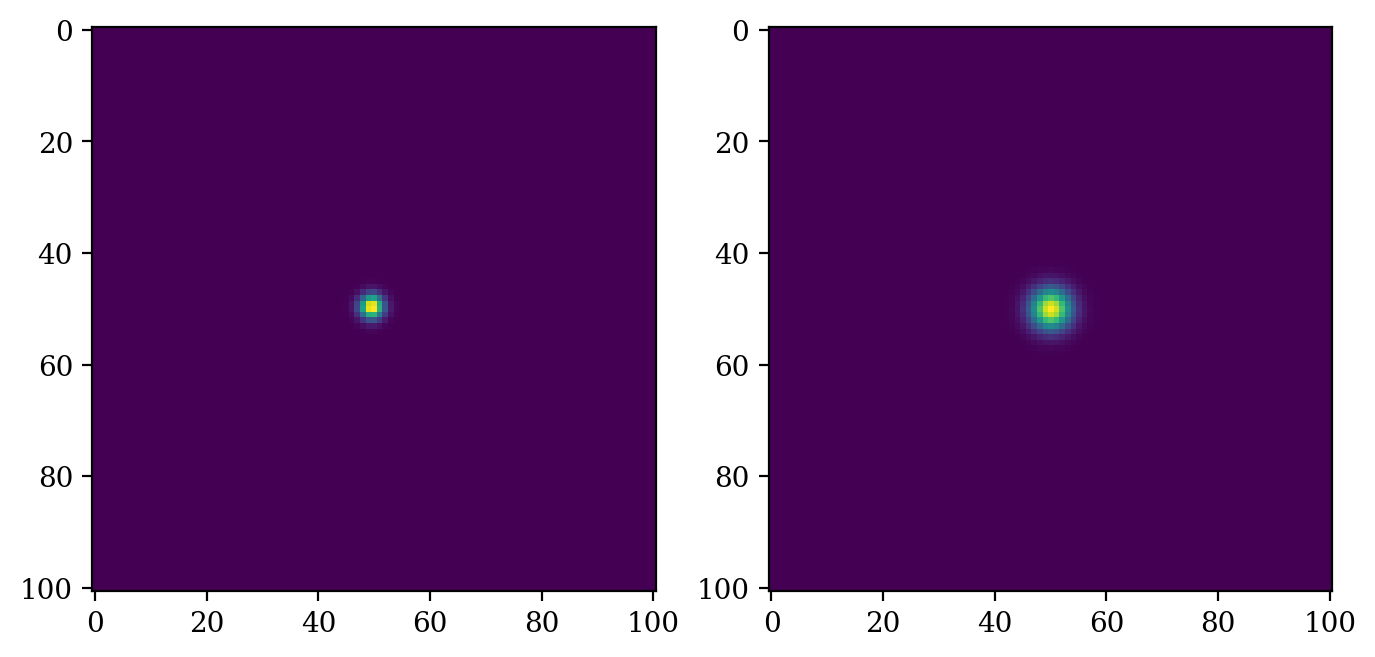

0.15500000000000005 (0.8069472678167479-0.6580382536671819j)


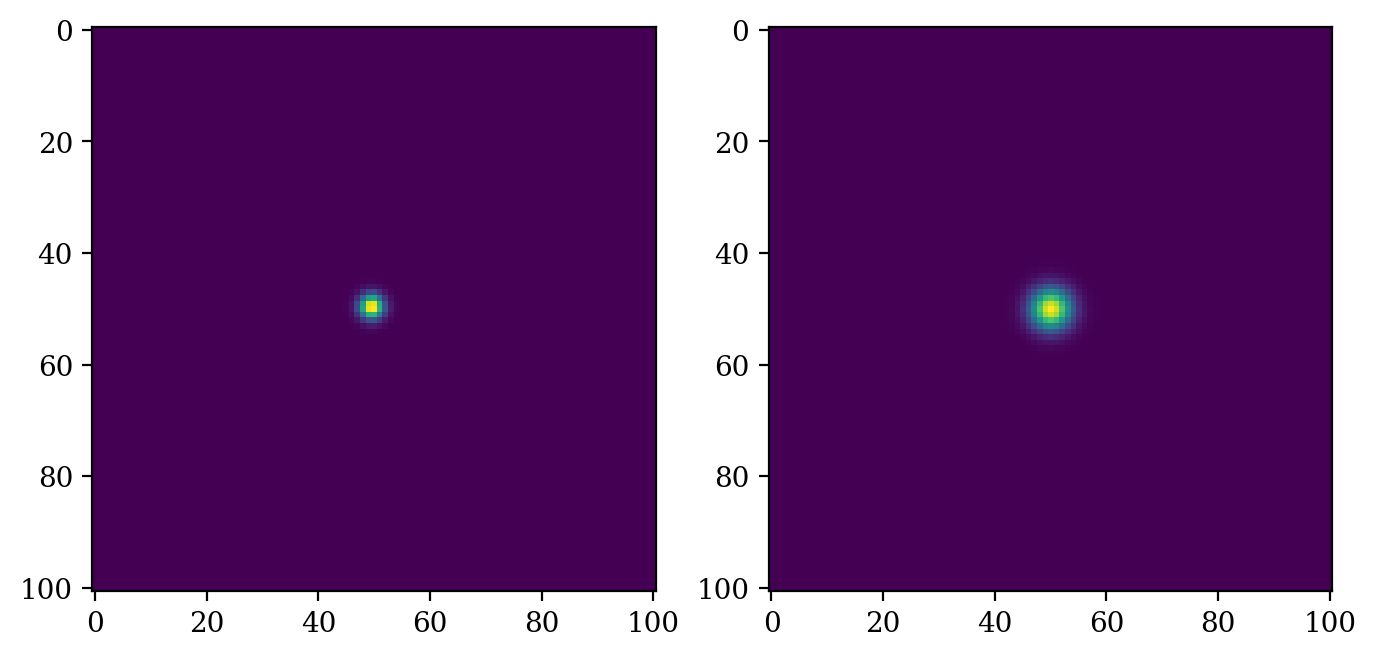

KeyboardInterrupt: 

In [272]:
t = 0
psi = psi0backup.copy()
while True:
    psi[1:-1,1:-1][1:-1,1:-1] = psi[1:-1,1:-1][1:-1,1:-1] + \
        1j*hb*dt/(2*m3*dx**2)*(\
            psi[2:,1:-1][1:-1,1:-1] + psi[:-2,1:-1][1:-1,1:-1] \
          + psi[1:-1,2:][1:-1,1:-1] + psi[1:-1,:-2][1:-1,1:-1] - 4*psi[1:-1,1:-1][1:-1,1:-1])\
       +1j*hb*dt/(2*m4*dx**2)*(\
            psi[1:-1,1:-1][2:,1:-1] + psi[1:-1,1:-1][:-2,1:-1] \
          + psi[1:-1,1:-1][1:-1,2:] + psi[1:-1,1:-1][1:-1,:-2] - 4*psi[1:-1,1:-1][1:-1,1:-1])
    t += dt
    print(t, psi[50,50][50,50])
    plt.subplot(1, 2, 1)
    plt.imshow(np.sum(np.abs(psi)**2, axis=(2,3)))
    plt.subplot(1, 2, 2)
    plt.imshow(np.sum(np.abs(psi)**2, axis=(0,1)))
    plt.show()

In [ ]:
dt

In [ ]:
1j*hb*dt/(2*m4*dx**2)

In [286]:
np.sum(np.abs(psi0backup)**2)*dx**4

1.0000000000001625

In [287]:
np.sum(np.abs(psi)**2)*dx**4

1.0119135229140013

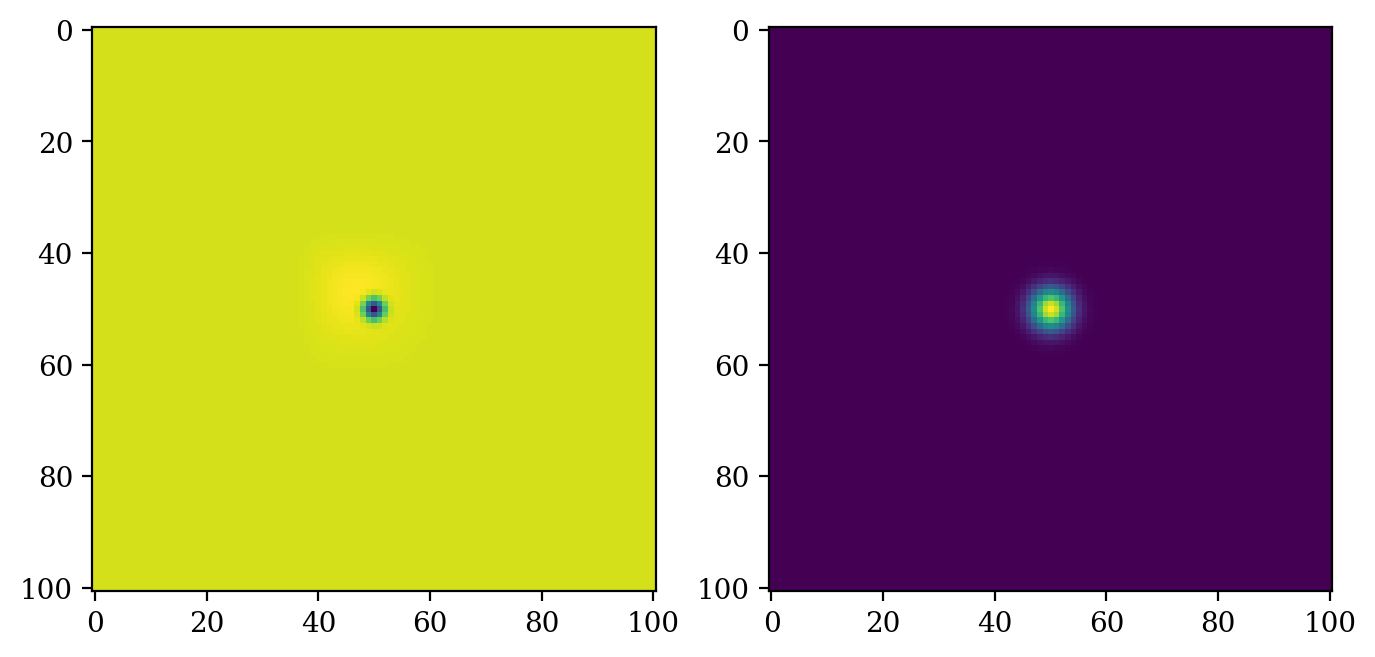

In [312]:
plt.subplot(1, 2, 1)
plt.imshow(np.sum(np.abs(psi)**2 - np.abs(psi0backup)**2, axis=(2,3)))
plt.subplot(1, 2, 2)
plt.imshow(np.sum(np.abs(psi)**2 - np.abs(psi0backup)**2, axis=(0,1)))
plt.show()

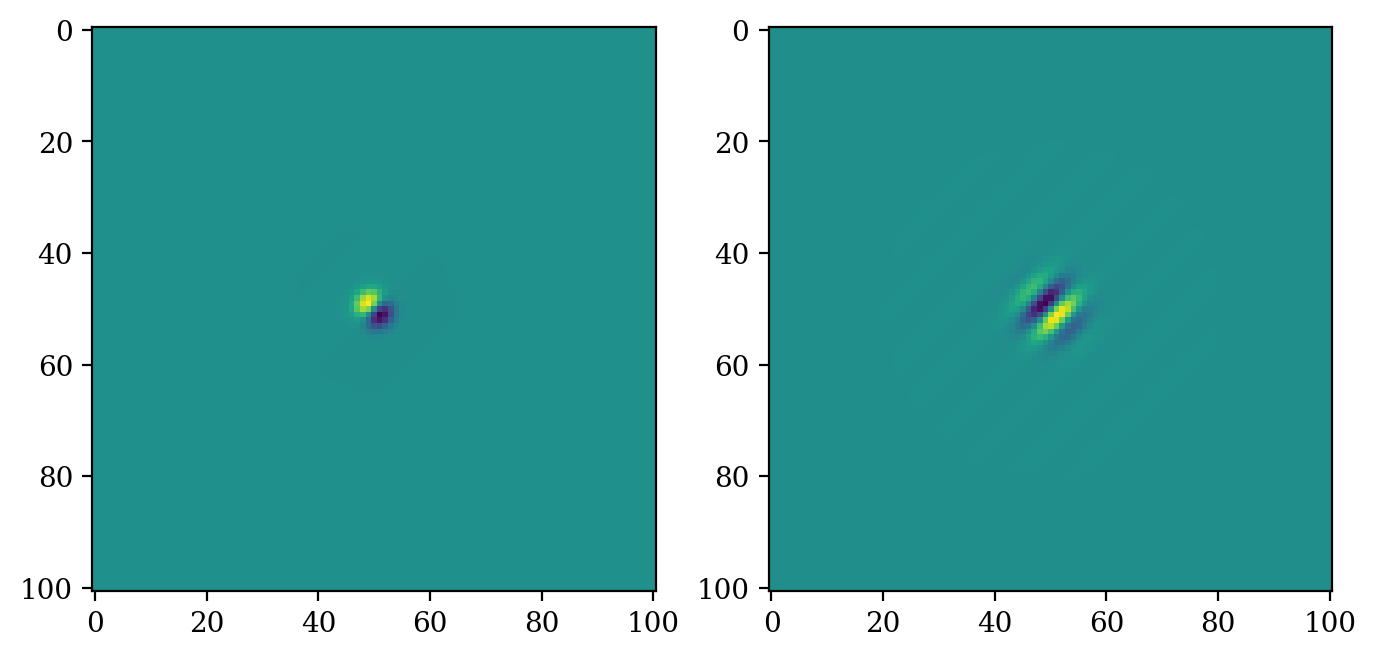

In [311]:
plt.subplot(1, 2, 1)
plt.imshow(np.sum(np.imag(psi0backup), axis=(2,3)))
plt.subplot(1, 2, 2)
plt.imshow(np.sum(np.imag(psi0backup), axis=(0,1)))
plt.show()

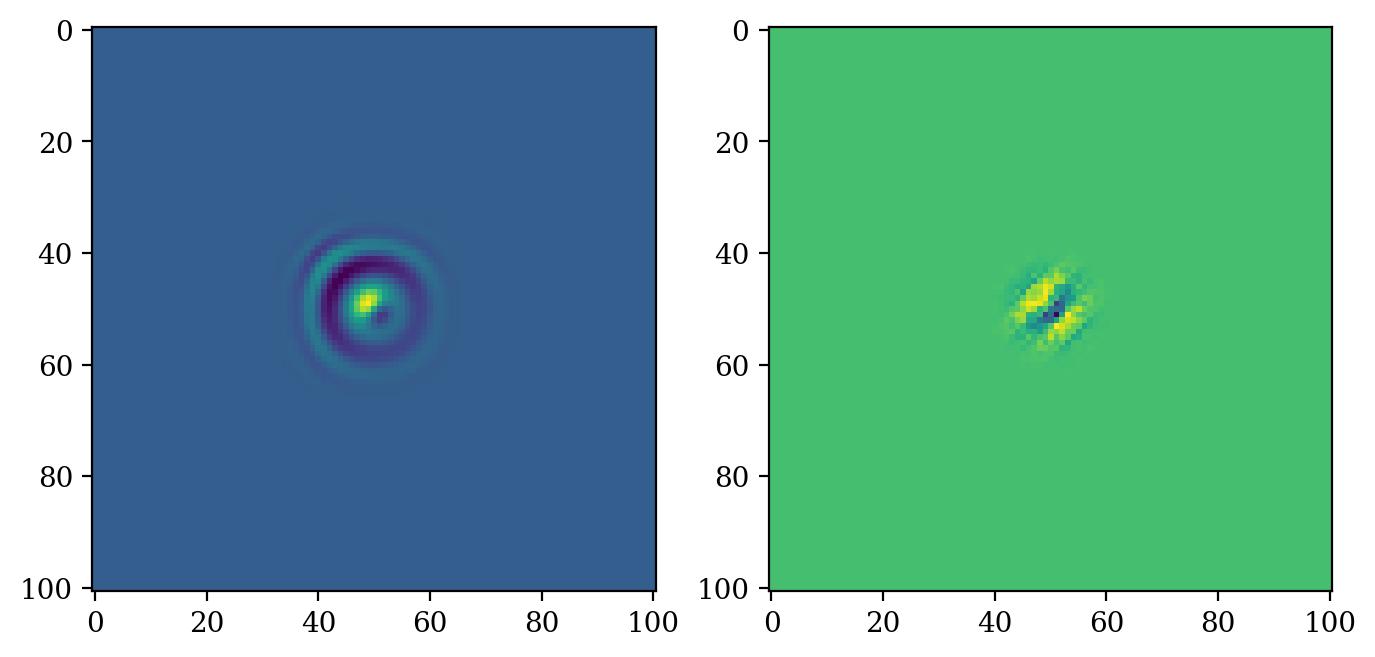

In [313]:
plt.subplot(1, 2, 1)
plt.imshow(np.sum(np.imag(psi0backup)-np.imag(psi), axis=(2,3)))
plt.subplot(1, 2, 2)
plt.imshow(np.sum(np.imag(psi0backup)-np.imag(psi), axis=(0,1)))
plt.show()

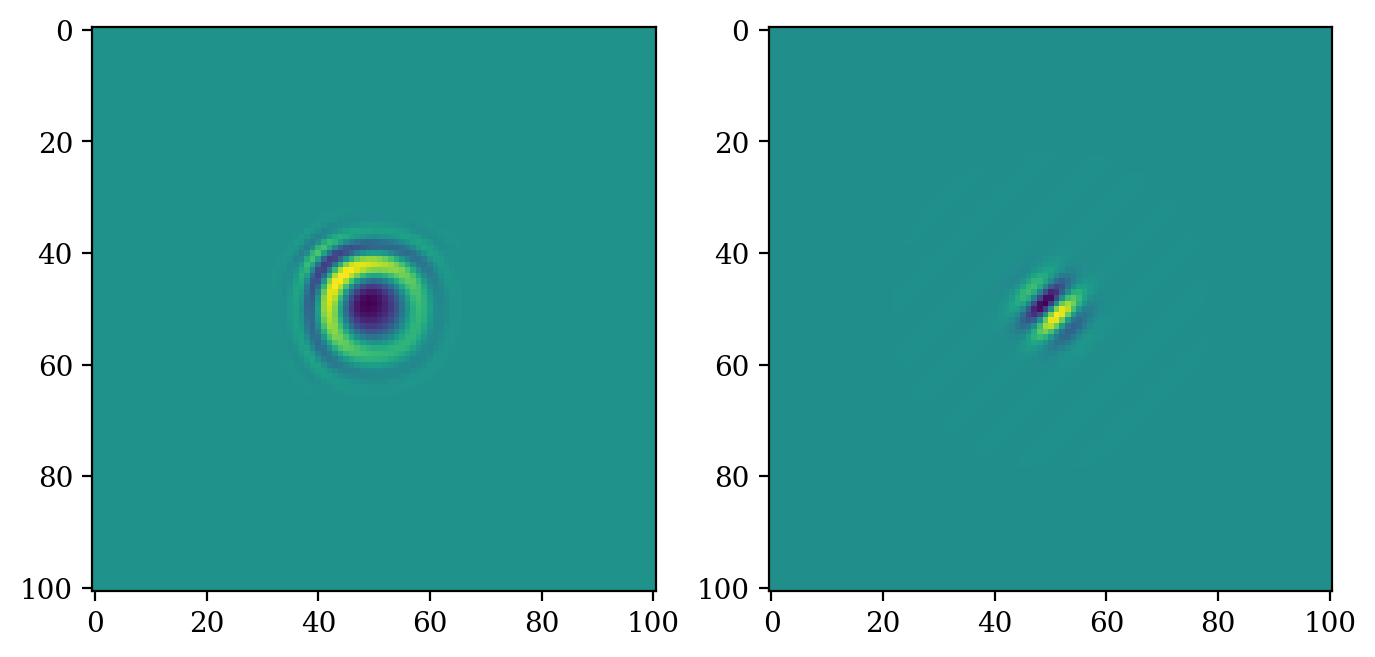

In [310]:
plt.subplot(1, 2, 1)
plt.imshow(np.sum(np.imag(psi), axis=(2,3)))
plt.subplot(1, 2, 2)
plt.imshow(np.sum(np.imag(psi), axis=(0,1)))
plt.show()

In [ ]:
psi[5,50,1,1]

In [299]:
tflip = 1

0.8150000000000006 (0.058184597705000556-0.2812005327097369j)


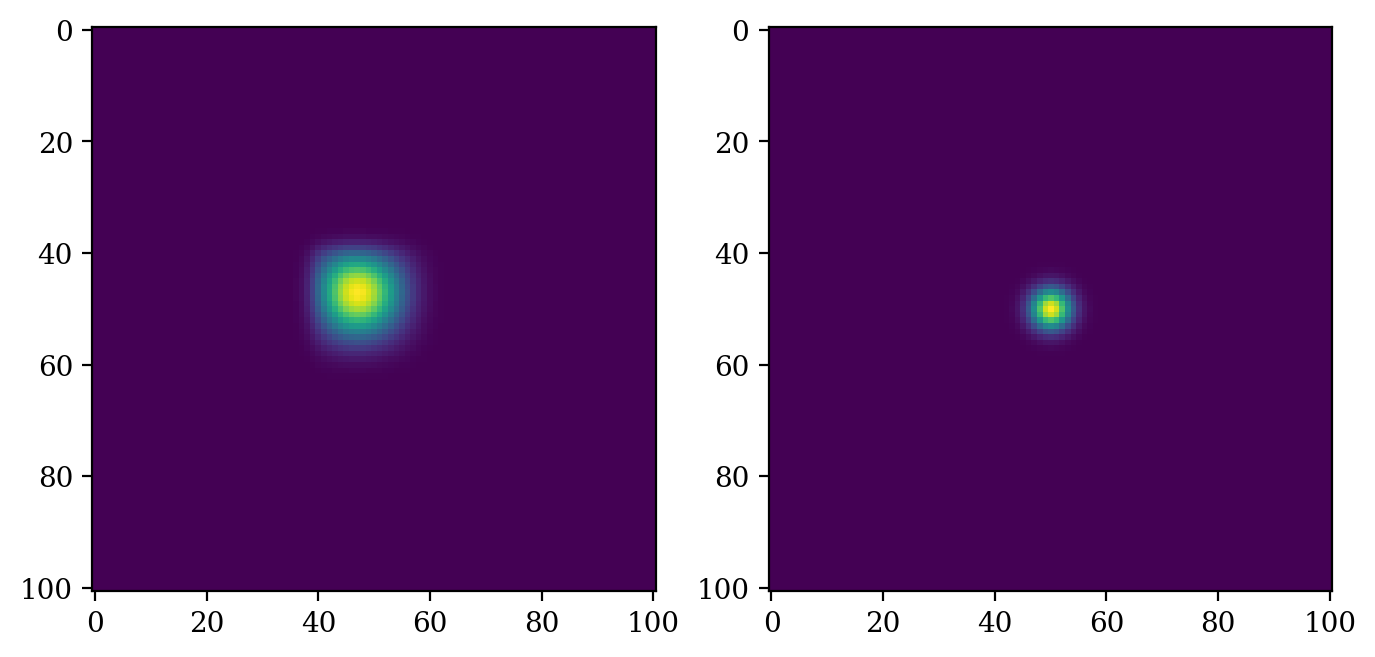

0.8200000000000006 (0.057505477256023216-0.2796290648012272j)


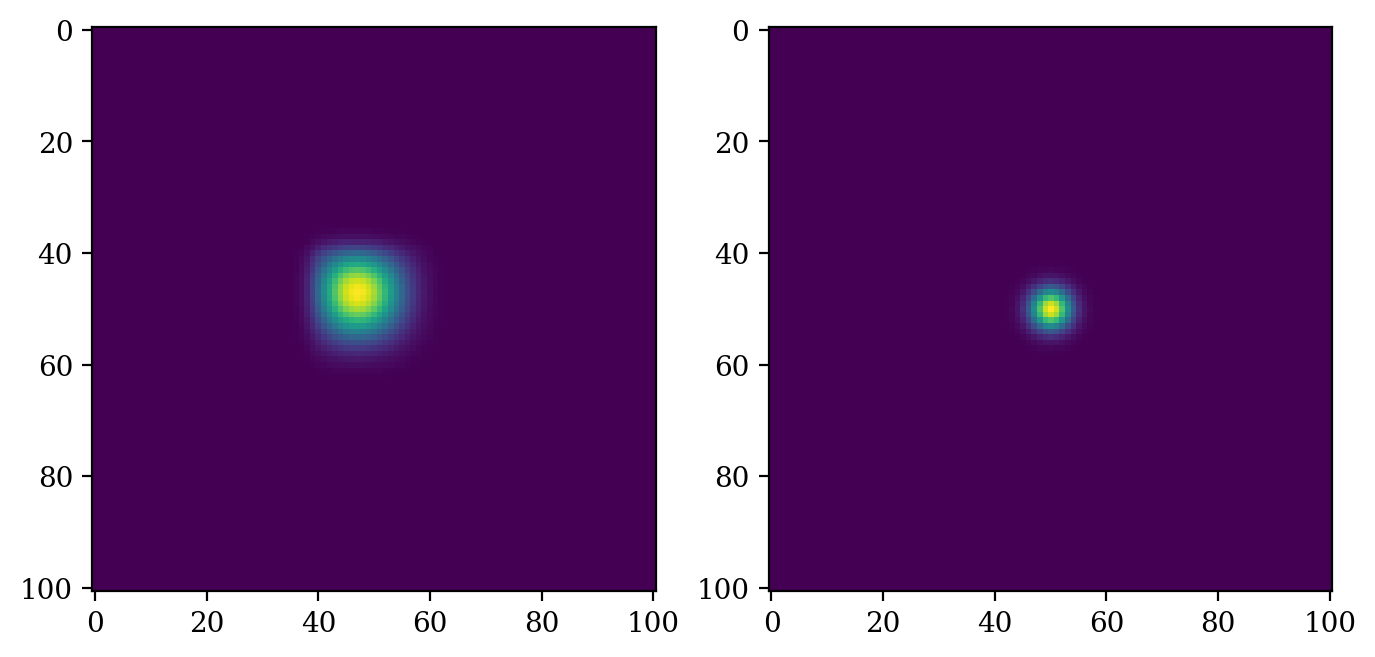

KeyboardInterrupt: 

In [309]:
while True:
    psi[1:-1,1:-1][1:-1,1:-1] = psi[1:-1,1:-1][1:-1,1:-1] + \
        1j*hb*dt/(2*m3*dx**2)*(\
            psi[2:,1:-1][1:-1,1:-1] + psi[:-2,1:-1][1:-1,1:-1] \
          + psi[1:-1,2:][1:-1,1:-1] + psi[1:-1,:-2][1:-1,1:-1] - 4*psi[1:-1,1:-1][1:-1,1:-1])\
       +1j*hb*dt/(2*m4*dx**2)*(\
            psi[1:-1,1:-1][2:,1:-1] + psi[1:-1,1:-1][:-2,1:-1] \
          + psi[1:-1,1:-1][1:-1,2:] + psi[1:-1,1:-1][1:-1,:-2] - 4*psi[1:-1,1:-1][1:-1,1:-1])
    t += dt
    print(t, psi[50,50][50,50])
    plt.subplot(1, 2, 1)
    plt.imshow(np.sum(np.abs(psi)**2, axis=(2,3)))
    plt.subplot(1, 2, 2)
    plt.imshow(np.sum(np.abs(psi)**2, axis=(0,1)))
    plt.show()
    